# Main Objective
Identify which machines will potentially fail and predict their failure type based on data extracted through sensors during the manufacturing process.

# Data dictionary
The dataset consists of 10 000 data points stored as rows with 8 features in columns:   

1. UID: unique identifier ranging from 1 to 10000    
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2   
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K   
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K   
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise   
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values   
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. 

The machine failure consists of five independent failure modes:
1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.




# Importing libraries

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime 
from sklearn.metrics import classification_report

In [2]:
machine_train = pd.read_csv('data/desafio_manutencao_preditiva_treino.csv')
machine_test = pd.read_csv('data/desafio_manutencao_preditiva_teste.csv')

In [3]:
# Displaying 20 random samples of 'machine_train'
machine_train.head(20)

udi product_id type  air_temperature_k  process_temperature_k  \
0     1     M14860    M              298.1                  308.6   
1     2     L47181    L              298.2                  308.7   
2     5     L47184    L              298.2                  308.7   
3     6     M14865    M              298.1                  308.6   
4     7     L47186    L              298.1                  308.6   
5     8     L47187    L              298.1                  308.6   
6     9     M14868    M              298.3                  308.7   
7    11     H29424    H              298.4                  308.9   
8    12     H29425    H              298.6                  309.1   
9    16     L47195    L              298.6                  309.2   
10   17     M14876    M              298.6                  309.2   
11   18     M14877    M              298.7                  309.2   
12   19     H29432    H              298.8                  309.2   
13   22     L47201    L              298.8                  309.3   
14   25     M14884    M              299.0                  309.4   
15   26     L47205    L              299.0                  309.5   
16   27     L47206    L              299.1                  309.5   
17   28     H29441    H              299.1                  309.4   
18   29     L47208    L              299.1                  309.4   
19   30     L47209    L              299.0                  309.4   

    rotational_speed_rpm  torque_nm  tool_wear_min failure_type  
0                   1551       42.8              0   No Failure  
1                   1408       46.3              3   No Failure  
2                   1408       40.0              9   No Failure  
3                   1425       41.9             11   No Failure  
4                   1558       42.4             14   No Failure  
5                   1527       40.2             16   No Failure  
6                   1667       28.6             18   No Failure  
7                   1782       23.9             24   No Failure  
8                   1423       44.3             29   No Failure  
9                   1542       48.4             42   No Failure  
10                  1311       46.6             44   No Failure  
11                  1410       45.6             47   No Failure  
12                  1306       54.5             50   No Failure  
13                  1450       44.8             63   No Failure  
14                  1561       37.3             70   No Failure  
15                  1861       23.3             73   No Failure  
16                  1512       39.0             75   No Failure  
17                  1811       24.6             77   No Failure  
18                  1439       44.2             82   No Failure  
19                  1693       30.1             84   No Failure

In [4]:
# Displaying 20 random samples of 'machine_test'
machine_test.head(20)

udi product_id type  air_temperature_k  process_temperature_k  \
0    446     L47625    L              297.5                  308.6   
1   7076     L54255    L              300.7                  310.5   
2   1191     L48370    L              297.2                  308.4   
3   2618     L49797    L              299.4                  309.1   
4   5067     L52246    L              304.1                  313.1   
5    191     L47370    L              298.2                  308.4   
6   2601     L49780    L              299.3                  309.0   
7   3300     L50479    L              301.3                  310.5   
8   6729     L53908    L              301.5                  310.9   
9   4824     L52003    L              303.5                  311.9   
10  6848     L54027    L              301.2                  311.4   
11  1238     M16097    M              297.1                  308.4   
12   199     L47378    L              298.4                  308.7   
13  3703     L50882    L              302.0                  311.2   
14  6984     M21843    M              300.7                  311.0   
15  3601     L50780    L              301.7                  310.5   
16  1737     L48916    L              298.4                  307.9   
17  6992     L54171    L              300.8                  311.1   
18  9921     H39334    H              298.5                  308.7   
19  5593     L52772    L              302.5                  311.9   

    rotational_speed_rpm  torque_nm  tool_wear_min  
0                   1793       26.7             70  
1                   1536       47.4            192  
2                   1460       42.1             41  
3                   1670       35.9             68  
4                   1550       30.9              9  
5                   1477       49.9             72  
6                   1422       47.3             25  
7                   1390       45.8             63  
8                   1891       23.2            122  
9                   1493       38.7             14  
10                  1757       28.0              6  
11                  1502       37.3            181  
12                  1588       35.0             99  
13                  1434       44.9             15  
14                  1334       53.9            150  
15                  1523       34.7            181  
16                  1544       35.9            132  
17                  1509       33.4            172  
18                  1450       43.9             28  
19                  1437       46.7             65

# Exploratory Data Analysis

In [5]:
# Displaying a summary of the train dataframe properties
machine_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


In [6]:
# Displaying a summary of the test dataframe properties
machine_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    3333 non-null   int64  
 1   product_id             3333 non-null   object 
 2   type                   3333 non-null   object 
 3   air_temperature_k      3333 non-null   float64
 4   process_temperature_k  3333 non-null   float64
 5   rotational_speed_rpm   3333 non-null   int64  
 6   torque_nm              3333 non-null   float64
 7   tool_wear_min          3333 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 208.4+ KB


**It is possible to note that there are no missing values in both train and test dataset since the number of elements in each column is equal to each dataset number of rows.**

In [7]:
# Basic statitic details
machine_train.describe(include='all')

udi product_id  type  air_temperature_k  \
count    6667.000000       6667  6667        6667.000000   
unique           NaN       6667     3                NaN   
top              NaN     M14860     L                NaN   
freq             NaN          1  4022                NaN   
mean     4994.589921        NaN   NaN         299.992515   
std      2896.125718        NaN   NaN           1.994710   
min         1.000000        NaN   NaN         295.300000   
25%      2496.500000        NaN   NaN         298.300000   
50%      4983.000000        NaN   NaN         300.000000   
75%      7510.500000        NaN   NaN         301.500000   
max     10000.000000        NaN   NaN         304.500000   

        process_temperature_k  rotational_speed_rpm    torque_nm  \
count             6667.000000           6667.000000  6667.000000   
unique                    NaN                   NaN          NaN   
top                       NaN                   NaN          NaN   
freq                      NaN                   NaN          NaN   
mean               309.992620           1537.419529    40.058512   
std                  1.488101            177.182908     9.950804   
min                305.700000           1168.000000     3.800000   
25%                308.800000           1422.500000    33.200000   
50%                310.000000           1503.000000    40.200000   
75%                311.100000           1612.000000    46.800000   
max                313.800000           2886.000000    76.600000   

        tool_wear_min failure_type  
count     6667.000000         6667  
unique            NaN            6  
top               NaN   No Failure  
freq              NaN         6435  
mean       108.098095          NaN  
std         63.359915          NaN  
min          0.000000          NaN  
25%         54.000000          NaN  
50%        108.000000          NaN  
75%        162.000000          NaN  
max        251.000000          NaN

In [8]:
machine_test.describe(include='all')

udi product_id  type  air_temperature_k  \
count   3333.000000       3333  3333        3333.000000   
unique          NaN       3333     3                NaN   
top             NaN     L47625     L                NaN   
freq            NaN          1  1978                NaN   
mean    5012.321932        NaN   NaN         300.029763   
std     2868.740345        NaN   NaN           2.011382   
min        3.000000        NaN   NaN         295.300000   
25%     2515.000000        NaN   NaN         298.400000   
50%     5023.000000        NaN   NaN         300.100000   
75%     7470.000000        NaN   NaN         301.600000   
max     9998.000000        NaN   NaN         304.400000   

        process_temperature_k  rotational_speed_rpm    torque_nm  \
count             3333.000000           3333.000000  3333.000000   
unique                    NaN                   NaN          NaN   
top                       NaN                   NaN          NaN   
freq                      NaN                   NaN          NaN   
mean               310.031443           1541.489649    39.843684   
std                  1.474842            183.411680    10.005058   
min                305.700000           1202.000000     4.600000   
25%                308.900000           1425.000000    33.100000   
50%                310.100000           1503.000000    39.900000   
75%                311.100000           1612.000000    46.600000   
max                313.800000           2861.000000    70.000000   

        tool_wear_min  
count     3333.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean       107.656766  
std         64.247195  
min          0.000000  
25%         51.000000  
50%        108.000000  
75%        163.000000  
max        253.000000

In [9]:
# Counting the number of distinct elements in each column of the train dataset
machine_train.nunique()

udi                      6667
product_id               6667
type                        3
air_temperature_k          93
process_temperature_k      82
rotational_speed_rpm      840
torque_nm                 547
tool_wear_min             243
failure_type                6
dtype: int64

In [10]:
# Counting the number of distinct elements in each column of the test dataset
machine_test.nunique()

udi                      3333
product_id               3333
type                        3
air_temperature_k          92
process_temperature_k      81
rotational_speed_rpm      712
torque_nm                 491
tool_wear_min             239
dtype: int64

**Except 'udi' and 'product_id' columns, all other columns have a number of unique elements lower than the number of rows of dataset. So, it is important to check the distribution in these distinct elements of the dataset.**

In [11]:
machine_train['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

In [12]:
(machine_train['failure_type'].value_counts(normalize=True)*100).round(2)

No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.94
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: failure_type, dtype: float64

**The failure_type values are highly imbalanced.**

In [13]:
 # Creating a new column with weights excluding "No Failure", to be used when "zooming in" only on failures
machine_train['weights'] = 0.0
machine_train['weights'] = machine_train['weights'].where(machine_train['failure_type'] == 'No Failure', other=1.0)
machine_train

udi product_id type  air_temperature_k  process_temperature_k  \
0         1     M14860    M              298.1                  308.6   
1         2     L47181    L              298.2                  308.7   
2         5     L47184    L              298.2                  308.7   
3         6     M14865    M              298.1                  308.6   
4         7     L47186    L              298.1                  308.6   
...     ...        ...  ...                ...                    ...   
6662   9995     L57174    L              298.8                  308.3   
6663   9996     M24855    M              298.8                  308.4   
6664   9997     H39410    H              298.9                  308.4   
6665   9999     H39412    H              299.0                  308.7   
6666  10000     M24859    M              299.0                  308.7   

      rotational_speed_rpm  torque_nm  tool_wear_min failure_type  weights  
0                     1551       42.8              0   No Failure      0.0  
1                     1408       46.3              3   No Failure      0.0  
2                     1408       40.0              9   No Failure      0.0  
3                     1425       41.9             11   No Failure      0.0  
4                     1558       42.4             14   No Failure      0.0  
...                    ...        ...            ...          ...      ...  
6662                  1634       27.9             12   No Failure      0.0  
6663                  1604       29.5             14   No Failure      0.0  
6664                  1632       31.8             17   No Failure      0.0  
6665                  1408       48.5             25   No Failure      0.0  
6666                  1500       40.2             30   No Failure      0.0  

[6667 rows x 10 columns]

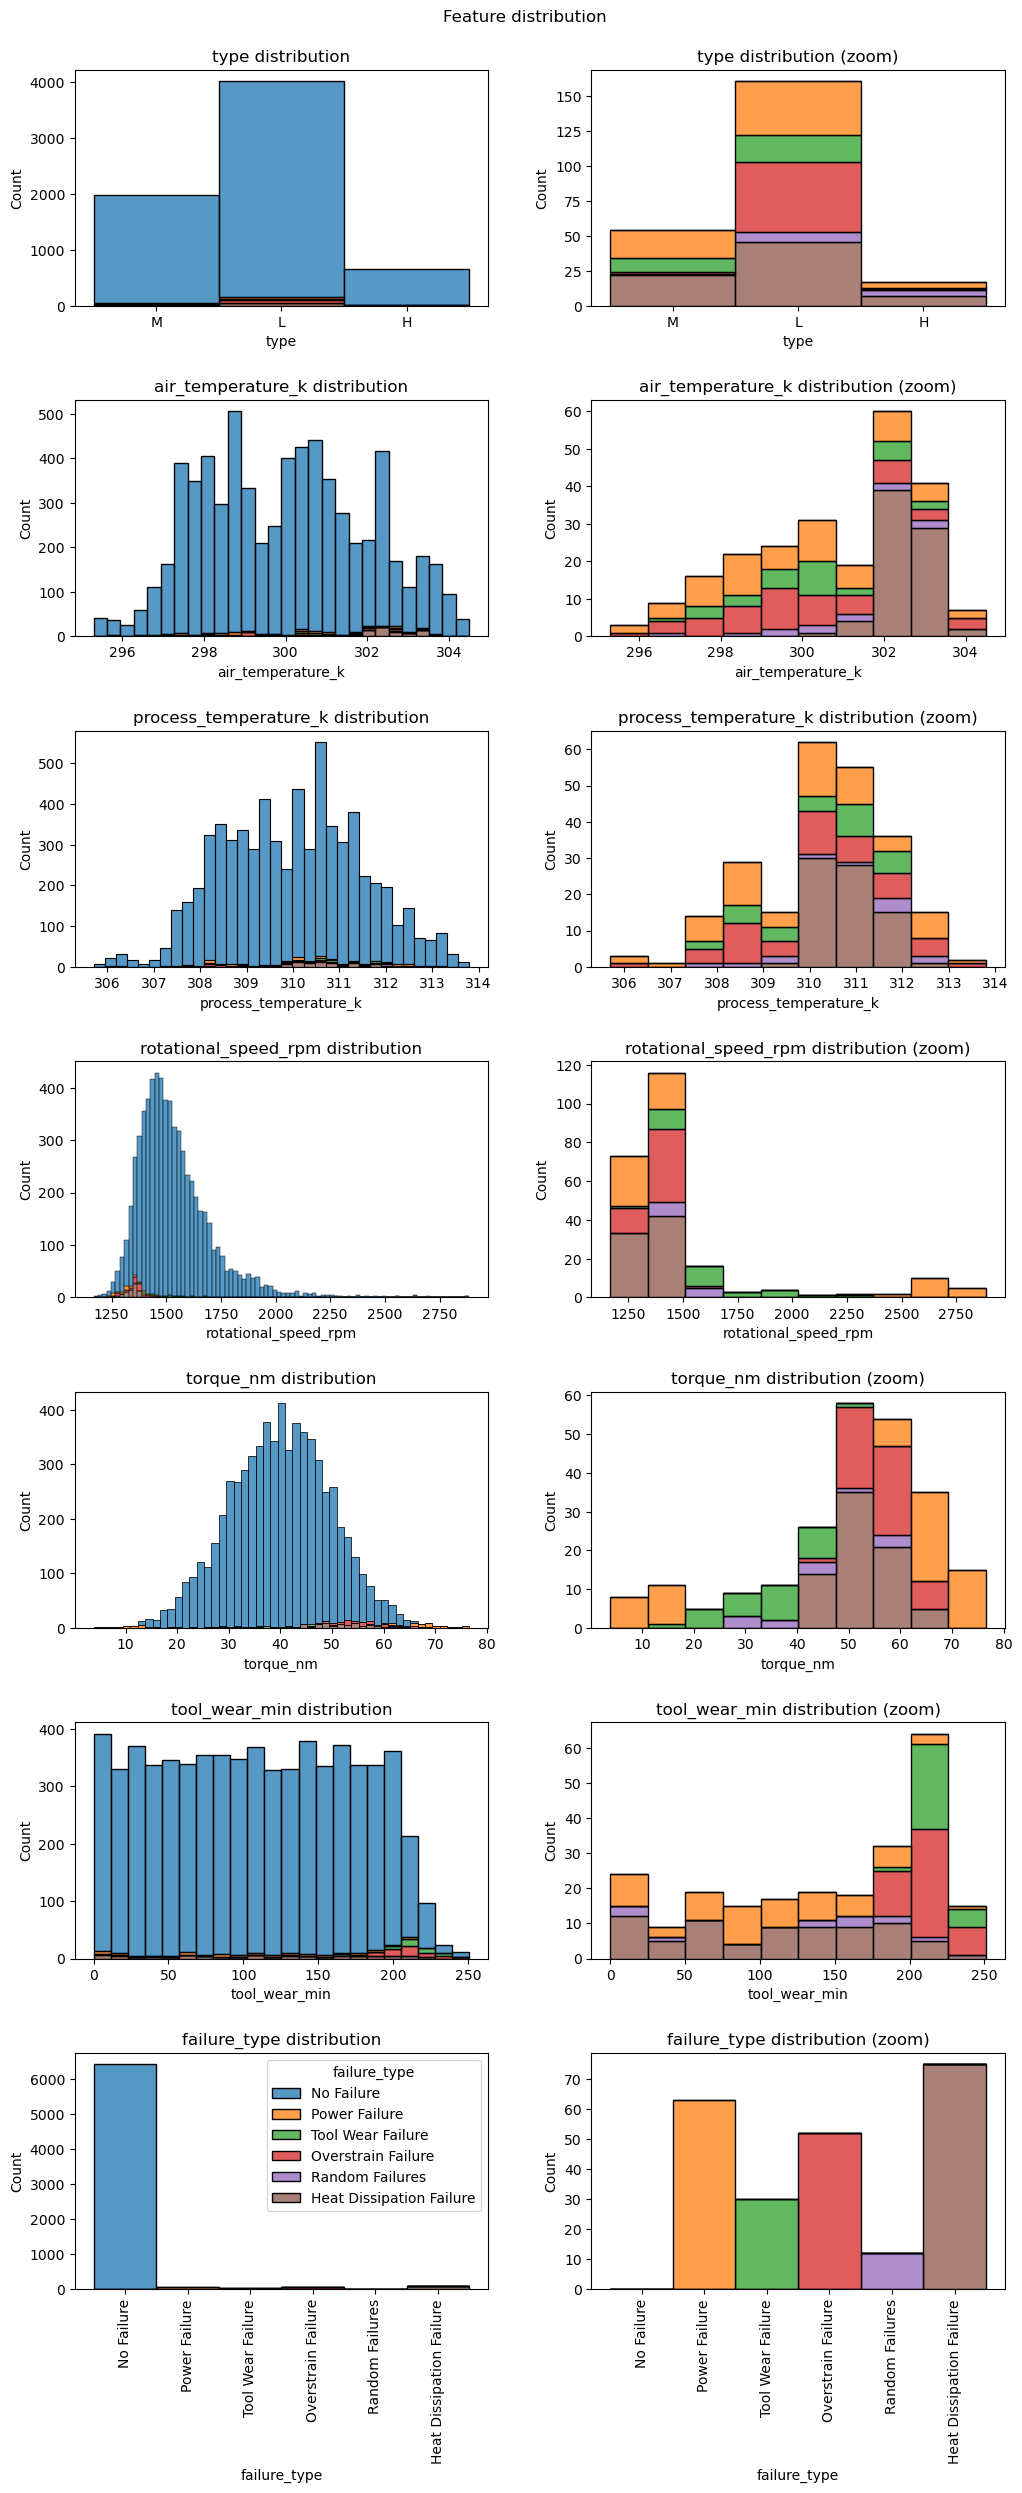

In [14]:
cols = ['type', 'air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'failure_type']
fig = plt.figure(figsize=(12, 30))
for i, feature in enumerate(cols):
    for zoomed in (False, True):
        ax = fig.add_subplot(8, 2, (2*i) + (1 if zoomed else 0) + 1)
        sns.histplot(
            x=feature,
            data=machine_train,
            stat='count',
            multiple='stack',
            hue='failure_type',
            weights='weights' if zoomed else None,
            legend=(i==6 and not zoomed),
            ax=ax,
        )
        ax.set_title(feature + f' distribution{" (zoom)" if zoomed else ""}')
        if feature == 'failure_type':
            plt.xticks(rotation=90)
plt.subplots_adjust(wspace=0.25, hspace=0.4, top=0.96)
fig.suptitle('Feature distribution')
plt.show()

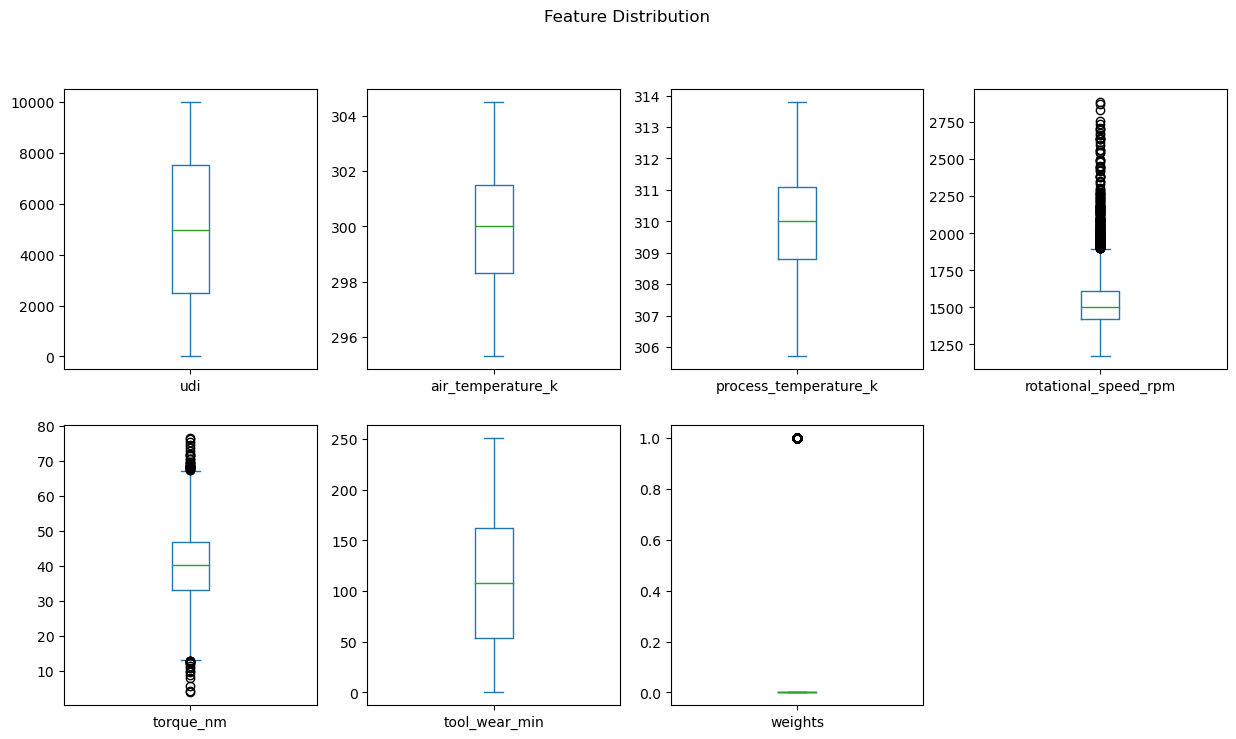

In [15]:
machine_train.plot.box(subplots=True, title= 'Feature Distribution', figsize=(15,8), layout=(2,4))
plt.show()

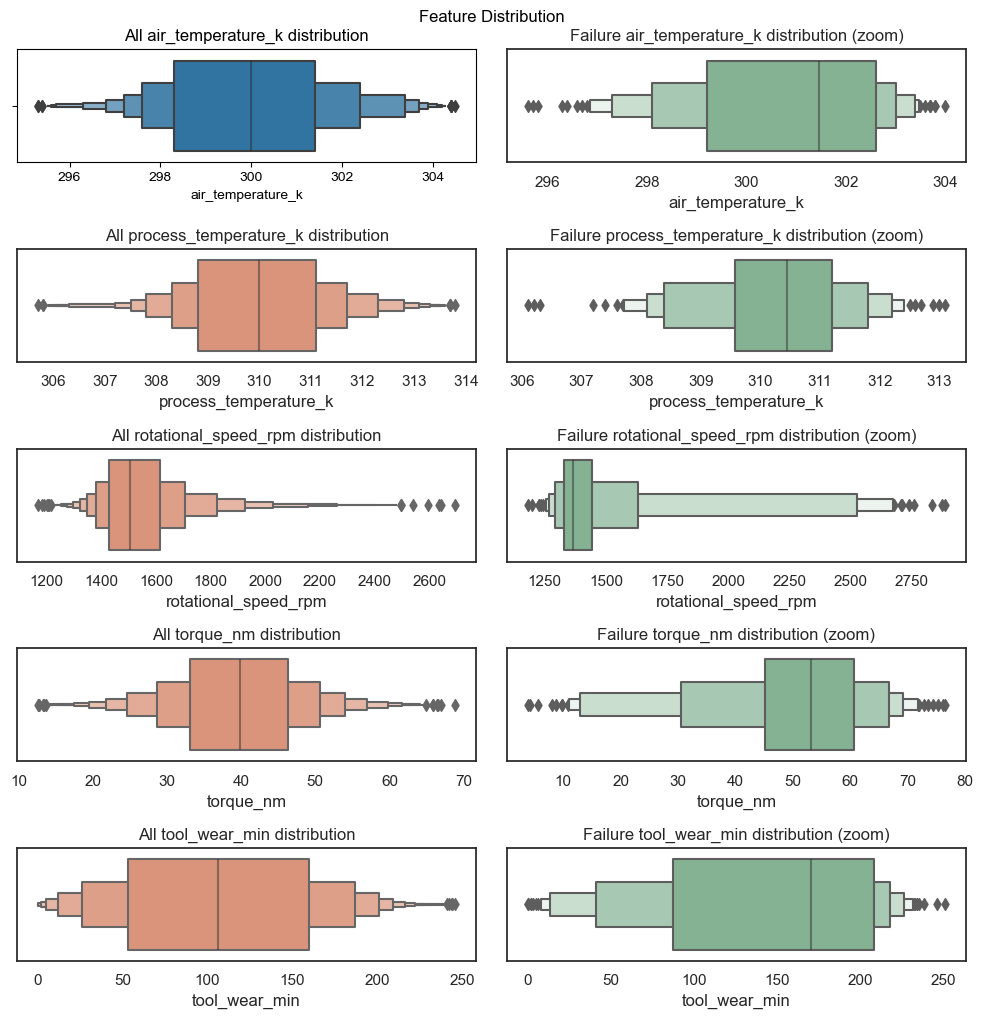

In [16]:
cols = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']
fig = plt.figure(figsize=(10, 16))
fig.suptitle('Feature Distribution')
for i, feature in enumerate(cols):
    for zoomed in (False, True):
        ax = fig.add_subplot(8, 2, (2*i) + (1 if zoomed else 0) + 1)
        if zoomed:
            sns.boxenplot(x=feature, data=machine_train[machine_train['failure_type'] != 'No Failure'])
        else:
            sns.boxenplot(x=feature, data=machine_train[machine_train['failure_type'] == 'No Failure'])
        sns.set_theme(style='white', palette ='flare' if zoomed else 'crest')
        ax.set_title('Failure ' + feature + ' distribution (zoom)' if zoomed else 'All ' + feature + ' distribution')
        if feature == 'failure_type':
            plt.xticks(rotation=90)
fig.tight_layout()
            
plt.show()

**It is possible to note that there are many outliers in the 'rotational_speed_rpm'and 'torque_n' columns.**

# Data Preprocessing

**Since there are 'tool_wear_min' values assigned as 0, it was assumed that the 5/3/2 minutes of tool wear atributted to machine quality H/M/L, respectively, were not included in those values.
Thus, a new column 'tool_wear_min_transf' was created adding the respective quality type values to the original 'tool_wear_min' values.**

In [17]:
machine_train_num = machine_train.copy()
machine_train_num['tool_wear_min_transf'] = machine_train_num['tool_wear_min'] + machine_train_num['type'].replace(['H', 'M', 'L'], [5, 3, 2])
machine_train_num.sample(10)

udi product_id type  air_temperature_k  process_temperature_k  \
2435  3627     M18486    M              302.2                  311.5   
3567  5340     M20199    M              303.4                  312.7   
6047  9080     H38493    H              297.3                  308.1   
2786  4157     M19016    M              302.0                  310.5   
6297  9451     M24310    M              298.0                  308.7   
6179  9284     M24143    M              298.3                  309.0   
964   1444     L48623    L              298.9                  310.1   
3333  4983     L52162    L              303.7                  313.0   
3553  5320     M20179    M              303.5                  312.7   
5235  7866     L55045    L              300.5                  311.9   

      rotational_speed_rpm  torque_nm  tool_wear_min failure_type  weights  \
2435                  1360       53.0             36   No Failure      0.0   
3567                  1594       32.8             79   No Failure      0.0   
6047                  1554       42.4            158   No Failure      0.0   
2786                  1823       25.1             87   No Failure      0.0   
6297                  1494       42.6             96   No Failure      0.0   
6179                  1802       27.5             71   No Failure      0.0   
964                   1602       38.2             58   No Failure      0.0   
3333                  1811       24.3            209   No Failure      0.0   
3553                  1402       47.0             23   No Failure      0.0   
5235                  1383       50.5             35   No Failure      0.0   

      tool_wear_min_transf  
2435                    39  
3567                    82  
6047                   163  
2786                    90  
6297                    99  
6179                    74  
964                     60  
3333                   211  
3553                    26  
5235                    37

## Converting categorical data to numerical data

type: 1 - Low, 2 - Medium and 3 - High

In [18]:
machine_train_num['type'] = machine_train_num['type'].replace(['L', 'M', 'H'],[1, 2, 3])
machine_train_num.head()

udi product_id  type  air_temperature_k  process_temperature_k  \
0    1     M14860     2              298.1                  308.6   
1    2     L47181     1              298.2                  308.7   
2    5     L47184     1              298.2                  308.7   
3    6     M14865     2              298.1                  308.6   
4    7     L47186     1              298.1                  308.6   

   rotational_speed_rpm  torque_nm  tool_wear_min failure_type  weights  \
0                  1551       42.8              0   No Failure      0.0   
1                  1408       46.3              3   No Failure      0.0   
2                  1408       40.0              9   No Failure      0.0   
3                  1425       41.9             11   No Failure      0.0   
4                  1558       42.4             14   No Failure      0.0   

   tool_wear_min_transf  
0                     3  
1                     5  
2                    11  
3                    14  
4                    16

Removing the letters 'L', 'M' and 'H' from 'product_id' values and converting it into numeric.

In [19]:
machine_train_num['product_id'] = machine_train_num['product_id'].map(lambda x: x.strip('LMH')).astype('int')

One-Hot Encode for the output variables

In [20]:
dummies = machine_train_num['failure_type'].str.get_dummies() # Using the function str.get_dummies() for One-Hot-Encode
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Heat Dissipation Failure  6667 non-null   int64
 1   No Failure                6667 non-null   int64
 2   Overstrain Failure        6667 non-null   int64
 3   Power Failure             6667 non-null   int64
 4   Random Failures           6667 non-null   int64
 5   Tool Wear Failure         6667 non-null   int64
dtypes: int64(6)
memory usage: 312.6 KB


In [21]:
# Concatenating new variables to the original dataframe
machine_train_ohe = pd.concat([machine_train_num, dummies[['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure','Random Failures', 'Tool Wear Failure']]], axis=1)
machine_train_ohe.head()

udi  product_id  type  air_temperature_k  process_temperature_k  \
0    1       14860     2              298.1                  308.6   
1    2       47181     1              298.2                  308.7   
2    5       47184     1              298.2                  308.7   
3    6       14865     2              298.1                  308.6   
4    7       47186     1              298.1                  308.6   

   rotational_speed_rpm  torque_nm  tool_wear_min failure_type  weights  \
0                  1551       42.8              0   No Failure      0.0   
1                  1408       46.3              3   No Failure      0.0   
2                  1408       40.0              9   No Failure      0.0   
3                  1425       41.9             11   No Failure      0.0   
4                  1558       42.4             14   No Failure      0.0   

   tool_wear_min_transf  Heat Dissipation Failure  No Failure  \
0                     3                         0           1   
1                     5                         0           1   
2                    11                         0           1   
3                    14                         0           1   
4                    16                         0           1   

   Overstrain Failure  Power Failure  Random Failures  Tool Wear Failure  
0                   0              0                0                  0  
1                   0              0                0                  0  
2                   0              0                0                  0  
3                   0              0                0                  0  
4                   0              0                0                  0

In [22]:
machine_train_ohe['No Failure'].value_counts()

1    6435
0     232
Name: No Failure, dtype: int64

## Treating outliers

According to Tukey's rule, there are possible outliers (located between the inner and the outer fence) and probable outliers (located outside the outer fence)
The inner fence is either Q1-1.5IQR, or Q3 + 1.5IQR. The outer fence is either Q1-3IQR, or above Q3 + 3IQR. IQR = Interquatile range.

In [23]:
def tukeys_method(dataframe, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1, q3 = dataframe[variable].quantile(0.25), dataframe[variable].quantile(0.75)
    iqr = q3 - q1
   
    # inner fence lower and upper end
    inner_fence_l = q1-(1.5*iqr)
    inner_fence_u = q3+(1.5*iqr)
    
    # outer fence lower and upper end
    outer_fence_l = q1-3*iqr
    outer_fence_u = q3+3*iqr
    
    # probable outliers
    outliers_prob = []
    outliers_poss = []
    for index, x in dataframe[variable].items():
        if x <= outer_fence_l or x >= outer_fence_u:
            outliers_prob.append(index)
        elif x <= inner_fence_l or x >= inner_fence_u:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

In [24]:
# Checking the outliers of the 'rotational_speed_rpm' and 'torque_nm' of the numeric dataframe
prob_rot, poss_rot = tukeys_method(machine_train_ohe, 'rotational_speed_rpm')
len(prob_rot), len(poss_rot)

(62, 207)

In [25]:
machine_train_ohe['failure_type'].iloc[prob_rot].value_counts()

No Failure           43
Power Failure        18
Tool Wear Failure     1
Name: failure_type, dtype: int64

In [26]:
prob_tor, poss_tor = tukeys_method(machine_train_ohe, 'torque_nm')
len(prob_tor), len(poss_tor)

(0, 47)

**As the number of probable outliers is relative low compared to the whole dataset, but represents a high proportion of the Power Failure data, it was decided not to treat outliers.**

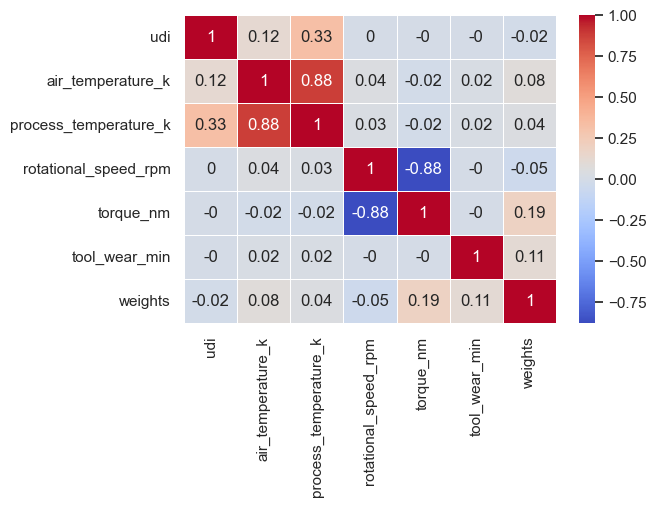

In [27]:
# Correlation matrix of features, without changing all features and taget to numerical
plt.figure(figsize=(6,4))
sns.heatmap(machine_train.corr().round(2), annot=True, linewidth=.5, cmap='coolwarm')
plt.show()

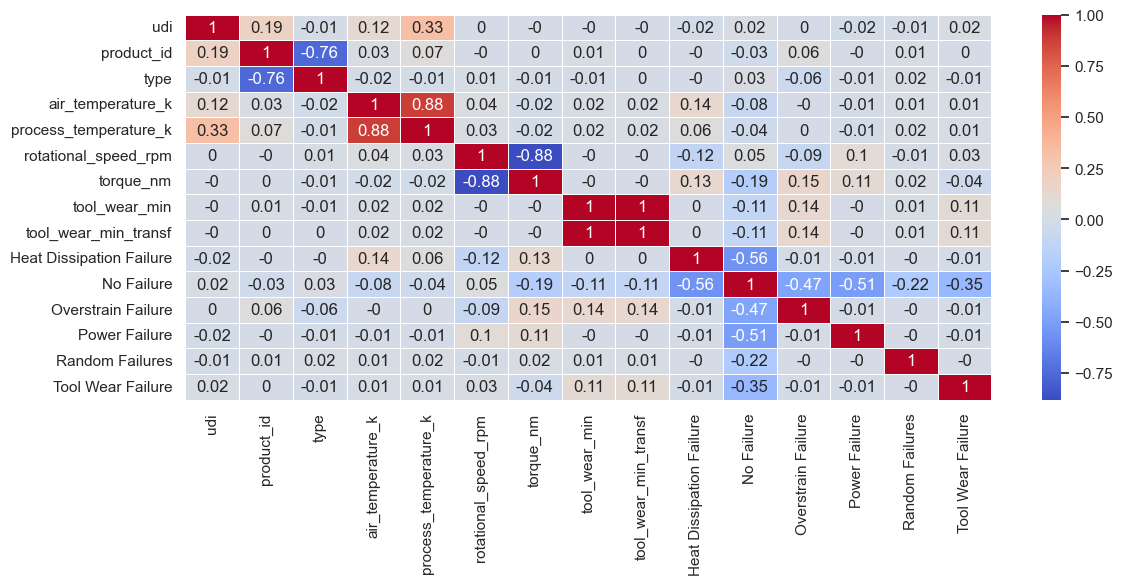

In [28]:
# Correlation matrix of features and taget with numerical values 
plt.figure(figsize=(13,5))
sns.heatmap(machine_train_ohe.drop(columns=['weights']).corr().round(2), annot=True, linewidth=.5, cmap='coolwarm')
plt.show()

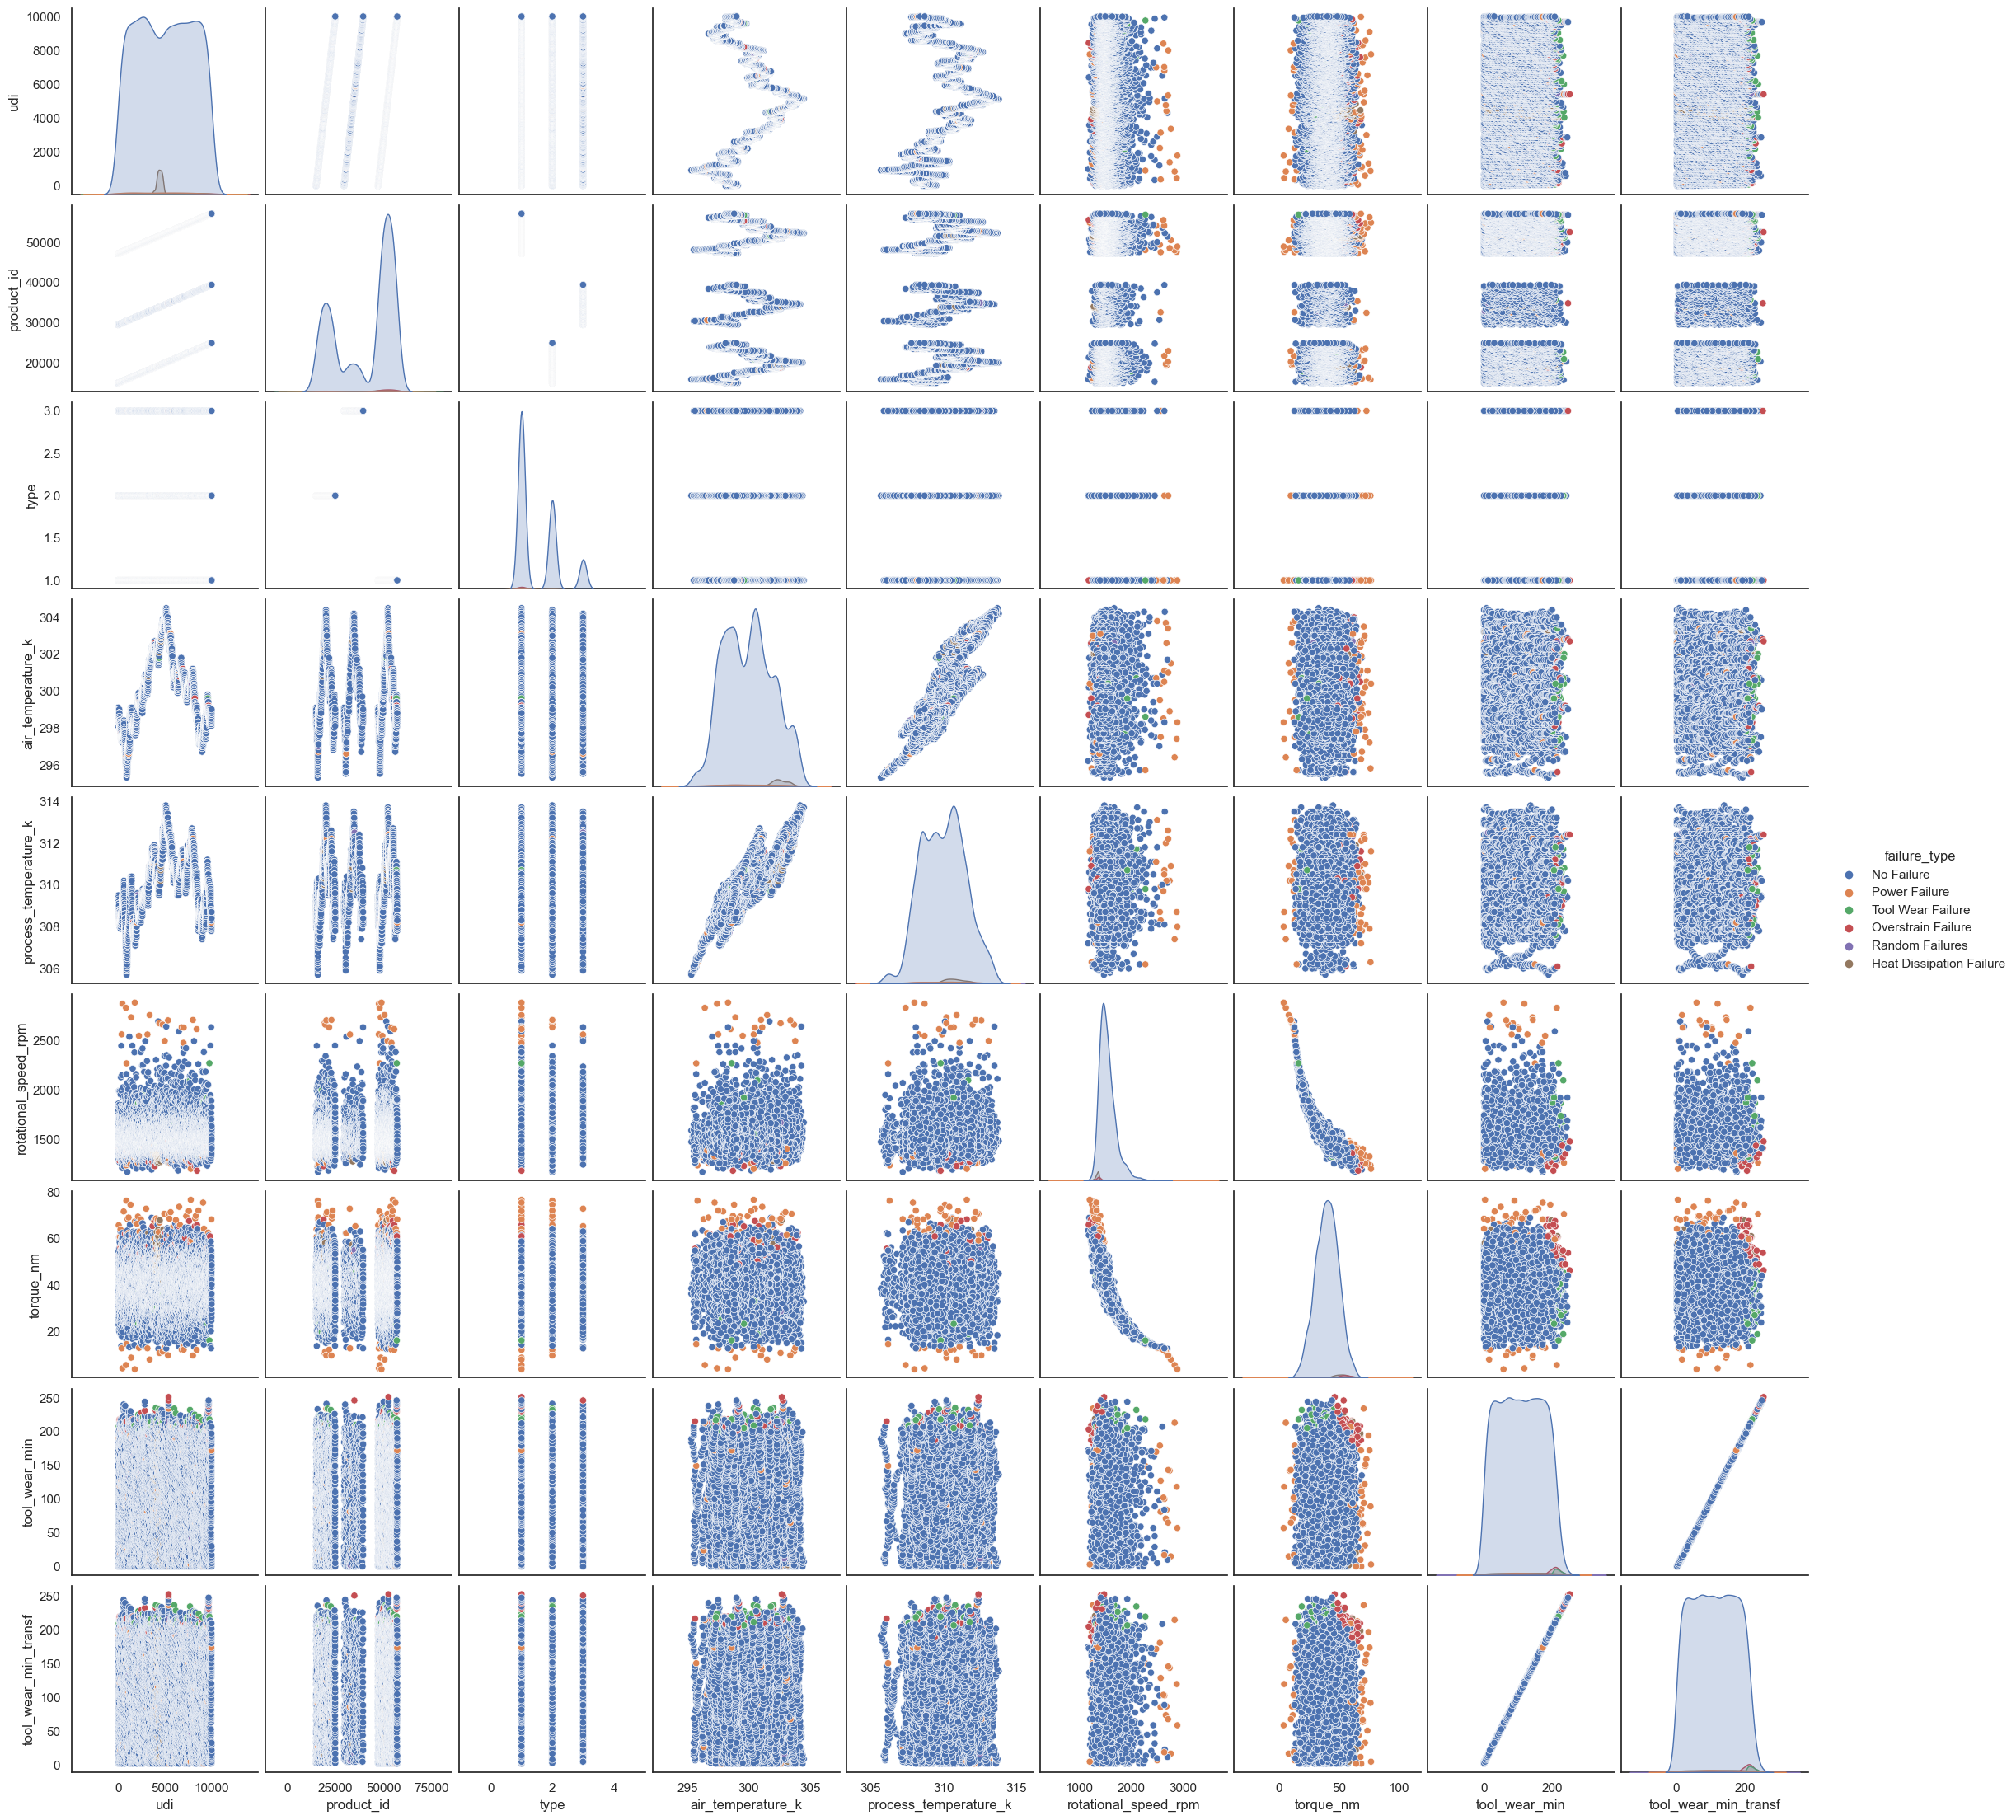

In [29]:
# Using pairplot to visualize possible correlations between variables.
sns.pairplot(machine_train_num.drop(columns=['weights']), hue='failure_type',palette='deep')
plt.show()

**Based on the exploratory data analises, apparently 'torque_nm'and tool_wear_min' have high impact on the failure condition.**

## Splitting the dataset 

In [30]:
from sklearn.model_selection import train_test_split

Splitting the numeric dataset with categorical output.

In [31]:
# Separate feature columns and target column
X_num = machine_train_num.drop(columns=['failure_type', 'weights'])  # feature columns
y_num = machine_train_num['failure_type']  # target column
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   int32  
 2   type                   6667 non-null   int64  
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   tool_wear_min_transf   6667 non-null   int64  
dtypes: float64(3), int32(1), int64(5)
memory usage: 442.9 KB


In [32]:
# Separate numerical X and y datasets into train and validation datasets using stratify mode to keep the same output class proportions
num_X_train, num_X_val, num_y_train, num_y_val = train_test_split(X_num, y_num, test_size = 0.2, random_state = 42, stratify=y_num)

num_X_train.info(),num_X_val.info()

Splitting the numerical dataset with numerical multi outputs.

In [33]:
# Separate feature columns and targets column
X_ohe = machine_train_ohe.drop(columns=['failure_type', 'weights', 'No Failure', 'Heat Dissipation Failure', 'Overstrain Failure', 'Power Failure', 'Tool Wear Failure', 'Random Failures'])  # feature columns
y_ohe = machine_train_ohe[['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure','Random Failures', 'Tool Wear Failure']]  # target column
X_ohe.info(), y_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   int32  
 2   type                   6667 non-null   int64  
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   tool_wear_min_transf   6667 non-null   int64  
dtypes: float64(3), int32(1), int64(5)
memory usage: 442.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Heat Dissipation Failure  6667 non-null   i

(None, None)

In [34]:
# Separate One Hot Encode X and y datasets into train and validation datasets using stratify mode to keep the same output class proportions.
ohe_X_train, ohe_X_val, ohe_y_train, ohe_y_val = train_test_split(X_ohe, y_ohe, test_size = 0.2, random_state = 42, stratify=y_ohe)

In [35]:
ohe_y_train

Heat Dissipation Failure  No Failure  Overstrain Failure  Power Failure  \
1236                         0           1                   0              0   
3861                         0           1                   0              0   
2192                         0           1                   0              0   
992                          0           1                   0              0   
2968                         0           1                   0              0   
...                        ...         ...                 ...            ...   
2759                         0           1                   0              0   
3766                         0           0                   0              0   
1084                         0           1                   0              0   
3319                         0           1                   0              0   
4316                         0           1                   0              0   

      Random Failures  Tool Wear Failure  
1236                0                  0  
3861                0                  0  
2192                0                  0  
992                 0                  0  
2968                0                  0  
...               ...                ...  
2759                0                  0  
3766                1                  0  
1084                0                  0  
3319                0                  0  
4316                0                  0  

[5333 rows x 6 columns]

## Oversampling the Imbalanced Data

In [36]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

In [37]:
strategy_25 = {'Heat Dissipation Failure': 575, 'Overstrain Failure' : 399, 'Power Failure': 483, 'Tool Wear Failure': 230, 'Random Failures': 30}

In [38]:
# Oversampling all failures to 25% of the outputs in the numeric dataset
num_oversample_25 = SMOTE(sampling_strategy=strategy_25, random_state=42)
num_X_train25, num_y_train25 = num_oversample_25.fit_resample(num_X_train, num_y_train)
num_y_train25

0              No Failure
1              No Failure
2              No Failure
3              No Failure
4              No Failure
              ...        
6859    Tool Wear Failure
6860    Tool Wear Failure
6861    Tool Wear Failure
6862    Tool Wear Failure
6863    Tool Wear Failure
Name: failure_type, Length: 6864, dtype: object

In [39]:
# Applying One Hot Encode to the num_y_train_25 to have the dataset oversampled with OHE
ohe_X_train25 = num_X_train25.copy()
ohe_y_train25 = num_y_train25.str.get_dummies()
ohe_y_train25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Heat Dissipation Failure  6864 non-null   int64
 1   No Failure                6864 non-null   int64
 2   Overstrain Failure        6864 non-null   int64
 3   Power Failure             6864 non-null   int64
 4   Random Failures           6864 non-null   int64
 5   Tool Wear Failure         6864 non-null   int64
dtypes: int64(6)
memory usage: 321.9 KB


# Machine learning Model building and evaluation

## Metrics

Specific metrics to evaluate the classification performed on imbalanced dataset.
- Precision: What percent of predictions were correct?
- Recall: What percent of the positive cases the model catch (sensitivity)? 
- Specificity: The proportion of the correctly predicted as negatives in the total number of negatives (True).
- Support is the number of samples of the class in the specified dataset.
- F1 Macro score: Unweighted mean of the F1 scores calculated per class. F1-Score is the Harmonic mean of precision and Recall, mostly used for uneven class distribution.
- Accuracy is the ratio of the number of correct predictions to the total number of input samples (probability).
- ROC_AUC: Receiver Operating Characteristics Are Under the Curve of True positive rate (positivos detectados/total de positivos detectados e não detectados) versus False Positive rate (número de negativos detectados/número total de negativos existentes).

In [40]:
Model_scores_train = pd.DataFrame(
    {},
    columns=[
        'Train - Model',
        'F1_macro_mean',
        'F1_macro_std',
        'Accuracy_mean',
        'Accuracy_std',
        'Roc_auc_ovo_mean',
        'Roc_auc_ovo_std',
    ],
)
Model_scores_val = pd.DataFrame(
    {},
    columns=[
        'Val - Model',
        'F1_macro',
        'Accuracy',
        'Roc_auc_ovo',
    ],
)

In [41]:
from sklearn.model_selection import StratifiedKFold

# Appling the Stratified K-Folds cross-validator provides train/test indices to split data in train/test sets, preserving the percentage of samples for each class when cross validation is applied 
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Create StratifiedKFold object

In [42]:
from sklearn.model_selection import cross_validate

# Checking model metrics using Cross-Validation 3-fold 
def cv_score(name_model, model, X, y):
    score = cross_validate(
        model,
        X,
        y,
        scoring=['f1_macro', 'accuracy', 'roc_auc_ovo'],
        cv=skf.split(X, y),
    )
    return (
        name_model,
        score['test_f1_macro'].mean().round(4),
        score['test_f1_macro'].std().round(4),
        score['test_accuracy'].mean().round(4),
        score['test_accuracy'].std().round(4),
        score['test_roc_auc_ovo'].mean().round(4),
        score['test_roc_auc_ovo'].std().round(4),
    )

In [43]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def val_score(name_model, model, X, y):
 return (
     name_model,
     f1_score(y, model.predict(X),
     average='macro'),
     accuracy_score(y, model.predict(X)),
     roc_auc_score(y, model.predict_proba(X), multi_class='ovo'))

## Decision Tree

A Decision Tree Model was built using 'balanced' mode for the 'class_weight', which uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input.

In [44]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced') # Creating an object for the class
dt_model.fit(num_X_train, num_y_train) # Training the model

print(classification_report_imbalanced(num_y_val, dt_model.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('dt_model', dt_model, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('dt_model', dt_model, num_X_val, num_y_val)
Model_scores_val.head()

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.733     0.733     0.997     0.733     0.855     0.712        15
              No Failure      0.985     0.987     0.565     0.986     0.747     0.581      1288
      Overstrain Failure      0.700     0.700     0.998     0.700     0.836     0.678        10
           Power Failure      0.500     0.462     0.995     0.480     0.678     0.435        13
         Random Failures      0.000     0.000     0.998     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.998     0.000     0.000     0.000         6

             avg / total      0.969     0.971     0.580     0.970     0.744     0.579      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0    dt_model  0.483164  0.970765     0.688167

In [45]:
Model_scores_train.head()

Train - Model  F1_macro_mean  F1_macro_std  Accuracy_mean  Accuracy_std  \
0      dt_model         0.4958        0.0397         0.9709        0.0042   

   Roc_auc_ovo_mean  Roc_auc_ovo_std  
0            0.6928           0.0184

Applying the Decision Tree Model to the balanced dataset

In [46]:
dt_model_25 = DecisionTreeClassifier(random_state=42) # Creating an object for the class
dt_model_25.fit(num_X_train25, num_y_train25) # Training the model

print(classification_report_imbalanced(num_y_val, dt_model_25.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('dt_model_25', dt_model_25, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('dt_model_25', dt_model_25, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.909     0.667     0.999     0.769     0.816     0.644        15
              No Failure      0.984     0.980     0.565     0.982     0.744     0.577      1288
      Overstrain Failure      0.700     0.700     0.998     0.700     0.836     0.678        10
           Power Failure      0.467     0.538     0.994     0.500     0.732     0.511        13
         Random Failures      0.000     0.000     0.994     0.000     0.000     0.000         2
       Tool Wear Failure      0.125     0.167     0.995     0.143     0.407     0.152         6

             avg / total      0.971     0.965     0.580     0.968     0.743     0.575      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0     dt_model  0.483164  0.970765     0.688167
1  dt_model_25  0.515698  0.964768     0.705161

 ## Random Forest Model

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') # Creating an object for the class
rf_model.fit(num_X_train, num_y_train) # Training the model

print(classification_report_imbalanced(num_y_val, rf_model.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('rf_model', rf_model, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('rf_model', rf_model, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      1.000     0.733     1.000     0.846     0.856     0.714        15
              No Failure      0.982     0.998     0.478     0.990     0.691     0.502      1288
      Overstrain Failure      0.833     0.500     0.999     0.625     0.707     0.475        10
           Power Failure      1.000     0.462     1.000     0.632     0.679     0.437        13
         Random Failures      0.000     0.000     1.000     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.999     0.000     0.000     0.000         6

             avg / total      0.975     0.981     0.496     0.976     0.689     0.501      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0     dt_model  0.483164  0.970765     0.688167
1  dt_model_25  0.515698  0.964768     0.705161
2     rf_model  0.515454  0.980510     0.864939

In [48]:
rf_model_25 = RandomForestClassifier(random_state=42) # Creating an object for the class
rf_model_25.fit(num_X_train25, num_y_train25) # Training the model

print(classification_report_imbalanced(num_y_val, rf_model_25.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('rf_model_25', rf_model_25, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('rf_model_25', rf_model_25, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.917     0.733     0.999     0.815     0.856     0.713        15
              No Failure      0.988     0.991     0.652     0.990     0.804     0.669      1288
      Overstrain Failure      0.900     0.900     0.999     0.900     0.948     0.890        10
           Power Failure      0.625     0.769     0.995     0.690     0.875     0.748        13
         Random Failures      0.000     0.000     1.000     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.998     0.000     0.000     0.000         6

             avg / total      0.977     0.980     0.664     0.978     0.802     0.667      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0     dt_model  0.483164  0.970765     0.688167
1  dt_model_25  0.515698  0.964768     0.705161
2     rf_model  0.515454  0.980510     0.864939
3  rf_model_25  0.565668  0.979760     0.871154

## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [50]:
lr  = LogisticRegression(class_weight='balanced', random_state=42, multi_class ="multinomial") # accounts for imbalanced multiclass dataset
classes = np.array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure','Random Failures', 'Tool Wear Failure'])
lr_model = MultiOutputClassifier(lr).fit(ohe_X_train, ohe_y_train)

In [51]:
from sklearn.datasets import make_multilabel_classification

def roc_auc_multi(X,y):
    n_sample=len(X)
    n_feature=9
    n_class=6
    X, y = make_multilabel_classification(n_samples=n_sample, n_features=n_feature, n_classes=n_class, random_state=42)
    y_score = np.transpose([y_pred[:, 1] for y_pred in lr_model.predict_proba(X)])
    return roc_auc_score(y, y_score, multi_class='ovo')

In [52]:
def append_f1_acc_roc(dataframe, model_name, f1, acc, ro, X, y):
    new_model_line = {dataframe.columns[0]:model_name,
                 f1:f1_score(y, lr_model.predict(X), average='macro'),
                 acc:accuracy_score(y, lr_model.predict(X)),
                 ro:roc_auc_multi(X, y)}
    return dataframe.append(new_model_line, ignore_index=True)
    

In [53]:
Model_scores_val =  append_f1_acc_roc(Model_scores_val, 'lr_model', 'F1_macro', 'Accuracy', 'Roc_auc_ovo', ohe_X_val, ohe_y_val)
Model_scores_train = append_f1_acc_roc(Model_scores_train, 'lr_model', 'F1_macro_mean', 'Accuracy_mean', 'Roc_auc_ovo_mean', ohe_X_train, ohe_y_train)

In [54]:
Model_scores_train

Train - Model  F1_macro_mean  F1_macro_std  Accuracy_mean  Accuracy_std  \
0      dt_model       0.495800        0.0397       0.970900        0.0042   
1   dt_model_25       0.479400        0.0081       0.970700        0.0008   
2      rf_model       0.447200        0.0393       0.976400        0.0030   
3   rf_model_25       0.509200        0.0323       0.979600        0.0029   
4      lr_model       0.424088           NaN       0.565535           NaN   

   Roc_auc_ovo_mean  Roc_auc_ovo_std  
0          0.692800           0.0184  
1          0.681700           0.0124  
2          0.864800           0.0107  
3          0.882200           0.0278  
4          0.471577              NaN

In [55]:
Model_scores_val

Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0     dt_model  0.483164  0.970765     0.688167
1  dt_model_25  0.515698  0.964768     0.705161
2     rf_model  0.515454  0.980510     0.864939
3  rf_model_25  0.565668  0.979760     0.871154
4     lr_model  0.408169  0.571964     0.474922

In [56]:
Model_scores_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Val - Model  5 non-null      object 
 1   F1_macro     5 non-null      float64
 2   Accuracy     5 non-null      float64
 3   Roc_auc_ovo  5 non-null      float64
dtypes: float64(3), object(1)
memory usage: 288.0+ bytes


## Support Vector Classification Model

In [57]:
from sklearn.svm import SVC
svc_model = SVC(random_state=42, class_weight='balanced', probability=True) # Creating an object for the class
svc_model.fit(num_X_train, num_y_train)

print(classification_report_imbalanced(num_y_val, svc_model.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('svc_model', svc_model, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] =  val_score('svc_model', svc_model, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.000     0.000     0.980     0.000     0.000     0.000        15
              No Failure      0.984     0.145     0.935     0.253     0.368     0.125      1288
      Overstrain Failure      0.012     1.000     0.395     0.024     0.629     0.419        10
           Power Failure      0.012     0.154     0.878     0.023     0.368     0.125        13
         Random Failures      0.007     0.500     0.893     0.014     0.668     0.429         2
       Tool Wear Failure      0.000     0.000     1.000     0.000     0.000     0.000         6

             avg / total      0.950     0.150     0.931     0.245     0.365     0.126      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0     dt_model  0.483164  0.970765     0.688167
1  dt_model_25  0.515698  0.964768     0.705161
2     rf_model  0.515454  0.980510     0.864939
3  rf_model_25  0.565668  0.979760     0.871154
4     lr_model  0.408169  0.571964     0.474922
5    svc_model  0.052321  0.149925     0.592318

In [58]:
svc_model_25 = SVC(random_state=42, class_weight='balanced', probability=True) # Creating an object for the class
svc_model_25.fit(num_X_train25, num_y_train25)

print(classification_report_imbalanced(num_y_val, svc_model_25.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('svc_model_25', svc_model_25, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('svc_model_25', svc_model_25, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.000     0.000     1.000     0.000     0.000     0.000        15
              No Failure      0.000     0.000     1.000     0.000     0.000     0.000      1288
      Overstrain Failure      0.012     1.000     0.395     0.024     0.629     0.419        10
           Power Failure      0.011     0.308     0.715     0.020     0.469     0.211        13
         Random Failures      0.007     0.500     0.893     0.014     0.668     0.429         2
       Tool Wear Failure      0.000     0.000     1.000     0.000     0.000     0.000         6

             avg / total      0.000     0.011     0.993     0.000     0.010     0.006      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0      dt_model  0.483164  0.970765     0.688167
1   dt_model_25  0.515698  0.964768     0.705161
2      rf_model  0.515454  0.980510     0.864939
3   rf_model_25  0.565668  0.979760     0.871154
4      lr_model  0.408169  0.571964     0.474922
5     svc_model  0.052321  0.149925     0.592318
6  svc_model_25  0.009752  0.011244     0.647428

### Model_evaluation

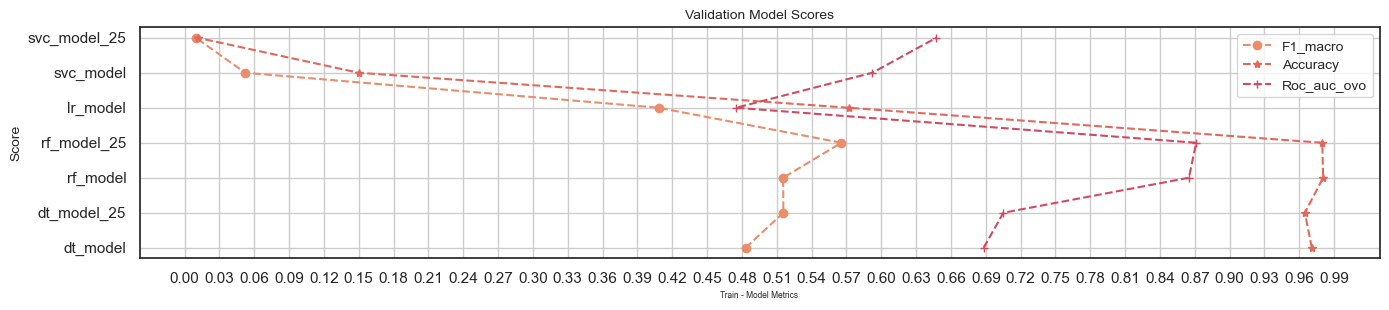

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

ax.plot(Model_scores_val['F1_macro'], Model_scores_val['Val - Model'], label='F1_macro', marker='o', linestyle='dashed')
ax.plot(Model_scores_val['Accuracy'], Model_scores_val['Val - Model'], label='Accuracy', marker='*', linestyle='dashed')
ax.plot(Model_scores_val['Roc_auc_ovo'], Model_scores_val['Val - Model'], label='Roc_auc_ovo', marker='+', linestyle='dashed')
ax.set_title('Validation Model Scores', fontsize=10)
ax.set_xlabel ('Train - Model Metrics', fontsize=6)
ax.set_ylabel ('Score', fontsize=10)
plt.legend(fontsize=10)
ax.set_xticks(np.arange(0., 1, 0.03))
plt.grid()

plt.show()

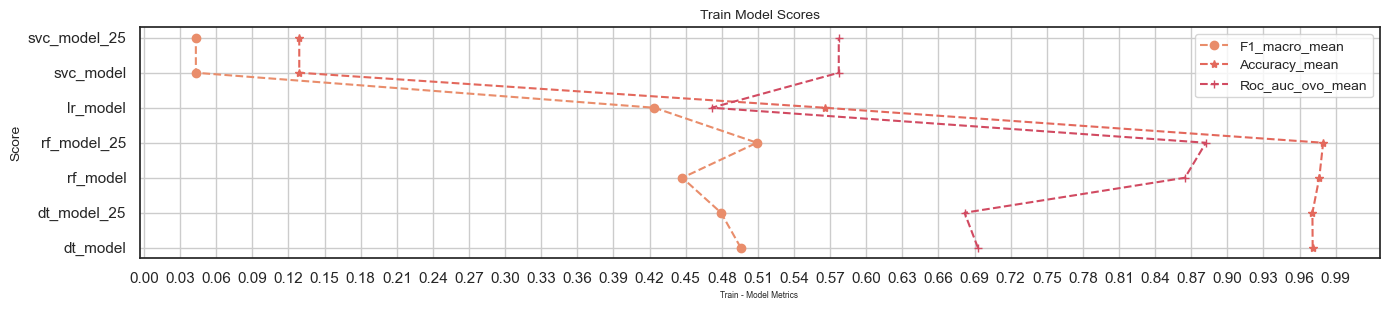

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

ax.plot(Model_scores_train['F1_macro_mean'], Model_scores_train['Train - Model'], label='F1_macro_mean', marker='o', linestyle='dashed')
ax.plot(Model_scores_train['Accuracy_mean'], Model_scores_train['Train - Model'], label='Accuracy_mean', marker='*', linestyle='dashed')
ax.plot(Model_scores_train['Roc_auc_ovo_mean'], Model_scores_train['Train - Model'], label='Roc_auc_ovo_mean', marker='+', linestyle='dashed')
ax.set_title('Train Model Scores', fontsize=10)
ax.set_xlabel ('Train - Model Metrics', fontsize=6)
ax.set_ylabel ('Score', fontsize=10)
plt.legend(fontsize=10)
ax.set_xticks(np.arange(0, 1, 0.03))
plt.grid()

plt.show()

In [61]:
from sklearn.metrics import plot_confusion_matrix

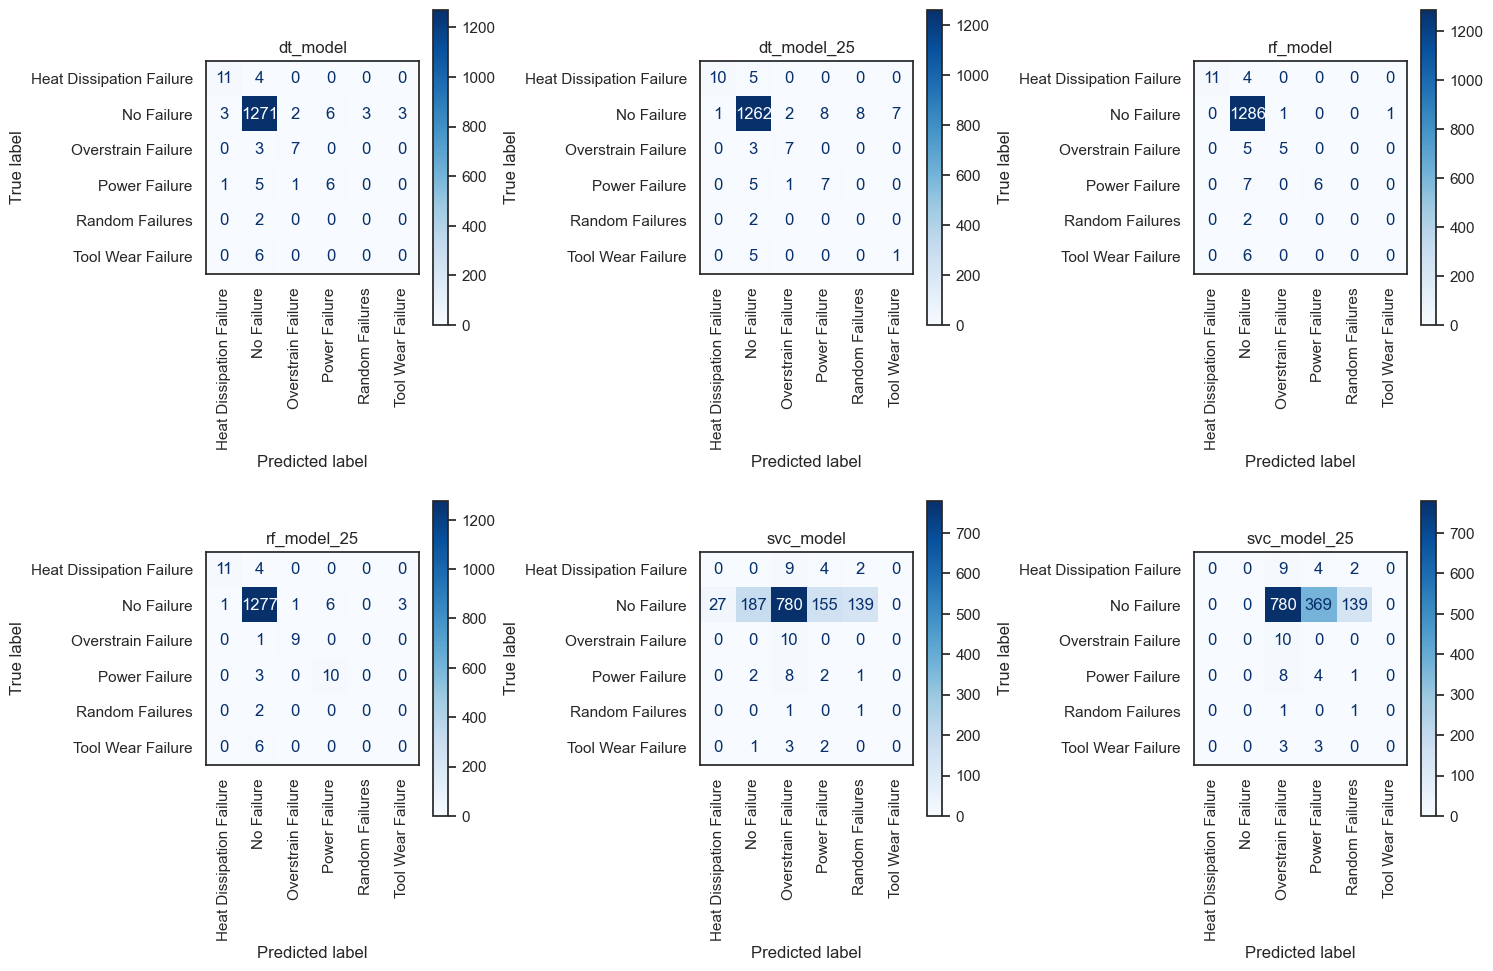

In [62]:
models = [dt_model, dt_model_25, rf_model, rf_model_25, svc_model, svc_model_25]
titles = ['dt_model', 'dt_model_25', 'rf_model', 'rf_model_25', 'svc_model', 'svc_model_25']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for model, ax, title in zip(models, axes.flatten(), titles):
    plot_confusion_matrix(model, 
                          num_X_val, 
                          num_y_val, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(title)
    ax.tick_params('x', labelrotation=90)
                          
plt.tight_layout()  
plt.show()

## Neural Network

In [63]:
from tensorflow import keras

In [64]:
num_y_train.shape

(5333,)

In [65]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'),
    # keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

In [66]:
imput_shape = (ohe_X_train.shape[-1],)

In [67]:
ohe_y_train

Heat Dissipation Failure  No Failure  Overstrain Failure  Power Failure  \
1236                         0           1                   0              0   
3861                         0           1                   0              0   
2192                         0           1                   0              0   
992                          0           1                   0              0   
2968                         0           1                   0              0   
...                        ...         ...                 ...            ...   
2759                         0           1                   0              0   
3766                         0           0                   0              0   
1084                         0           1                   0              0   
3319                         0           1                   0              0   
4316                         0           1                   0              0   

      Random Failures  Tool Wear Failure  
1236                0                  0  
3861                0                  0  
2192                0                  0  
992                 0                  0  
2968                0                  0  
...               ...                ...  
2759                0                  0  
3766                1                  0  
1084                0                  0  
3319                0                  0  
4316                0                  0  

[5333 rows x 6 columns]

In [68]:
output_bias = keras.initializers.Constant([-1.943955935, 1.443060566,  -2.104526505, -2.020466515, -2.743966814, -2.344850563]) # Setting the output bias as log([pos/neg]) for all columns

model_out6 = keras.Sequential(
    [
    keras.layers.Dense(16, activation='relu', input_shape=imput_shape),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(6, activation='sigmoid', bias_initializer=output_bias)
    ])
    
model_out6.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Compiling the model_out6_0 with bias
optimizer = keras.optimizers.Adam( # Adam as a faster optimization algorithm than Stochastic Gradient Descent
    learning_rate=0.001)  # Setting the default value for the learning rate 
epochs = 1000 # 1000 Epochs is the number of loops that through the training dataset
batch_size = 32 # Setting 100 as the batch size (number of samples used to estimate model error in an epoch), the default value is 32

model0_out6 = keras.models.clone_model(model_out6)
model0_out6.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
    )
    
# Using Early Stopping for stop training before it starts to overfitting
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1) # Verbose=1 will show you an animated progress bar of epochs

es_monitor = model0_out6.fit(ohe_X_train,
                         ohe_y_train,
                         batch_size=batch_size,
                         callbacks=[es_callback],
                         epochs=epochs, verbose=1,
                         validation_data=(ohe_X_val, ohe_y_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5333 samples, validate on 1334 samples
Epoch 1/1000
5333/5333 [==============================] - 1s 111us/sample - loss: 2382.5495 - tp: 4253.0000 - tn: 18893.0000 - precision: 0.3537 - recall: 0.7975 - auc: 0.7523 - prc: 0.3279 - val_loss: 90.8913 - val_tp: 1288.0000 - val_tn: 6624.0000 - val_precision: 0.9655 - val_recall: 0.9655 - val_auc: 0.9793 - val_prc: 0.9443
Epoch 2/1000
5333/5333 [==============================] - 0s 47us/sample - loss: 426.3267 - tp: 4765.0000 - tn: 23537.0000 - precision: 0.6037 - recall: 0.8935 - auc: 0.8879

In [70]:
# Predicting the values for all the data
m0out6_ypred = model0_out6.predict(ohe_X_val)
# Converting values to integer format
m0out6_ypred = pd.DataFrame(m0out6_ypred)
m0out6_ypred = m0out6_ypred.round(0).astype(int)
m0out6_ypred.describe()

0       1       2       3            4       5
count  1334.0  1334.0  1334.0  1334.0  1334.000000  1334.0
mean      0.0     1.0     0.0     0.0     0.000750     0.0
std       0.0     0.0     0.0     0.0     0.027379     0.0
min       0.0     1.0     0.0     0.0     0.000000     0.0
25%       0.0     1.0     0.0     0.0     0.000000     0.0
50%       0.0     1.0     0.0     0.0     0.000000     0.0
75%       0.0     1.0     0.0     0.0     0.000000     0.0
max       0.0     1.0     0.0     0.0     1.000000     0.0

In [71]:
m0out6_ypred.value_counts()

0  1  2  3  4  5
0  1  0  0  0  0    1333
            1  0       1
dtype: int64

**Although the scores of the neural network seemed to be good, the model using bias predicted almost all data as 'No Failure'.**

In [72]:
# Compiling the model_out6_0 with no bias
optimizer = keras.optimizers.Adam(learning_rate=0.001) # Adam as a faster optimization algorithm than Stochastic Gradient Descent and setting the default value for the learning rate 
epochs = 1000 # 1000 Epochs is the number of loops that through the training dataset
batch_size = 100 # Setting 100 as the batch size (number of samples used to estimate model error in an epoch), the default value is 32

model_0 = keras.models.clone_model(model_out6)
model_0.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
    )
    
# Using Early Stopping for stop training before it starts to overfitting
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1) # Verbose=1 will show you an animated progress bar of epochs

es_monitor = model_0.fit(ohe_X_train,
                         ohe_y_train,
                         batch_size=batch_size,
                         callbacks=[es_callback],
                         epochs=epochs, verbose=1,
                         validation_data=(ohe_X_val, ohe_y_val))

Train on 5333 samples, validate on 1334 samples
Epoch 1/1000
5333/5333 [==============================] - 0s 83us/sample - loss: 2040.9459 - tp: 3194.0000 - tn: 18059.0000 - precision: 0.2707 - recall: 0.5989 - auc: 0.6325 - prc: 0.2389 - val_loss: 374.6205 - val_tp: 1303.0000 - val_tn: 5381.0000 - val_precision: 0.5027 - val_recall: 0.9768 - val_auc: 0.8918 - val_prc: 0.4976
Epoch 2/1000
5333/5333 [==============================] - 0s 22us/sample - loss: 1137.9433 - tp: 3613.0000 - tn: 20114.0000 - precision: 0.3555 - recall: 0.6775 - auc: 0.7116 - prc: 0.3096 - val_loss: 108.3285 - val_tp: 1297.0000 - val_tn: 5761.0000 - val_precision: 0.5879 - val_recall: 0.9723 - val_auc: 0.9181 - val_prc: 0.5802
Epoch 3/1000
5333/5333 [==============================] - 0s 21us/sample - loss: 667.7377 - tp: 3952.0000 - tn: 20873.0000 - precision: 0.4056 - recall: 0.7410 - auc: 0.7573 - prc: 0.3573 - val_loss: 45.5361 - val_tp: 1288.0000 - val_tn: 6541.0000 - val_precision: 0.9090 - val_recall: 0.96

In [73]:
# Predicting the values for all the data
m0_ypred = model_0.predict(ohe_X_val)
# Converting values to integer format
m0_ypred = pd.DataFrame(m0_ypred)
m0_ypred = m0_ypred.round(0).astype(int)
m0_ypred.describe()

0       1       2       3       4       5
count  1334.0  1334.0  1334.0  1334.0  1334.0  1334.0
mean      0.0     1.0     0.0     0.0     0.0     0.0
std       0.0     0.0     0.0     0.0     0.0     0.0
min       0.0     1.0     0.0     0.0     0.0     0.0
25%       0.0     1.0     0.0     0.0     0.0     0.0
50%       0.0     1.0     0.0     0.0     0.0     0.0
75%       0.0     1.0     0.0     0.0     0.0     0.0
max       0.0     1.0     0.0     0.0     0.0     0.0

**Either with and whithout bias_initializer the neural network model performed poorly in the imbalanced dataset.**

The NN model using no bias also predict all data as 'No Failure'.

# Hyperparameter Tunning

## Random Search CV

In [74]:
#Importing Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

In [75]:
Model_scores_val

Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0      dt_model  0.483164  0.970765     0.688167
1   dt_model_25  0.515698  0.964768     0.705161
2      rf_model  0.515454  0.980510     0.864939
3   rf_model_25  0.565668  0.979760     0.871154
4      lr_model  0.408169  0.571964     0.474922
5     svc_model  0.052321  0.149925     0.592318
6  svc_model_25  0.009752  0.011244     0.647428

**Considering the above scores, Decision Tree and Random Forest model were chosen to evaluate hyperparameter tunning for model improvment.**

### Decision Tree

In [76]:
#Checking Decision Tree parameters in use
print('Decision Tree Parameters currently in use:\n')
dt_model.get_params()

Decision Tree Parameters currently in use:



{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [77]:
# Different parameters to test in Decision Tree

class_weight = ['None', 'balanced']    # Used to provide a weight or bias for each output class
criterion = ['gini', 'entropy']        # what criteria to consider
max_depth = [2, 5, 10, 30, 60, 100]             # Maximum number of levels in trees
min_samples_leaf = [1, 2, 4, 8]           # Min number of data points allowed in a leaf node
max_features = ['auto', 'sqrt']        # Max number of features considered for splitting a node

dt_parameters = {'class_weight': class_weight,
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}
dt_parameters

{'class_weight': ['None', 'balanced'],
 'criterion': ['gini', 'entropy'],
 'max_depth': [2, 5, 10, 30, 60, 100],
 'min_samples_leaf': [1, 2, 4, 8],
 'max_features': ['auto', 'sqrt']}

In [78]:
# Random search of parameters 
start_time = datetime.now()

# Searching across 100 different combinations, and use all available cores, using 3 fold cross validation
dt_random = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_distributions = dt_parameters, n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs = -1) # n_jobs -1 means that all processor can run in parallel
dt_random.fit(num_X_train, num_y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Duration: 0:00:04.755637


In [79]:
dt_random.best_params_

{'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [80]:
# Applying the best parameter to the Decision Tree baseline model
dt_model_h1 = DecisionTreeClassifier(**dt_random.best_params_, random_state=42)

# Fitting the model with the data
dt_model_h1.fit(num_X_train, num_y_train)

print(classification_report_imbalanced(num_y_val, dt_model_h1.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('dt_model_h1', dt_model_h1, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('dt_model_h1', dt_model_h1, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.636     0.467     0.997     0.538     0.682     0.441        15
              No Failure      0.982     0.990     0.500     0.986     0.704     0.519      1288
      Overstrain Failure      0.667     0.600     0.998     0.632     0.774     0.575        10
           Power Failure      0.500     0.462     0.995     0.480     0.678     0.435        13
         Random Failures      0.000     0.000     0.998     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.999     0.000     0.000     0.000         6

             avg / total      0.965     0.970     0.517     0.968     0.699     0.515      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0      dt_model  0.483164  0.970765     0.688167
1   dt_model_25  0.515698  0.964768     0.705161
2      rf_model  0.515454  0.980510     0.864939
3   rf_model_25  0.565668  0.979760     0.871154
4      lr_model  0.408169  0.571964     0.474922
5     svc_model  0.052321  0.149925     0.592318
6  svc_model_25  0.009752  0.011244     0.647428
7   dt_model_h1  0.439353  0.970015     0.651811

In [81]:
# Random search of parameters 
start_time = datetime.now()

# Searching across 100 different combinations, and use all available cores, using 3 fold cross validation
dt_random_25 = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_distributions = dt_parameters, n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs = -1) # n_jobs -1 means that all processor can run in parallel
dt_random_25.fit(num_X_train25, num_y_train25)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Duration: 0:00:01.681422


In [82]:
dt_random_25.best_params_

{'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [83]:
# Applying the best parameter to the Decision Tree baseline model trained with the oversampled dataset.
dt_model_25_h1 = DecisionTreeClassifier(**dt_random_25.best_params_, random_state=42)

# Fitting the model with the data
dt_model_25_h1.fit(num_X_train25, num_y_train25)

print(classification_report_imbalanced(num_y_val, dt_model_25_h1.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('dt_model_25_h1', dt_model_25_h1, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('dt_model_25_h1', dt_model_25_h1, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.765     0.867     0.997     0.812     0.930     0.853        15
              No Failure      0.987     0.970     0.652     0.979     0.796     0.653      1288
      Overstrain Failure      0.636     0.700     0.997     0.667     0.835     0.677        10
           Power Failure      0.360     0.692     0.988     0.474     0.827     0.664        13
         Random Failures      0.000     0.000     0.996     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.992     0.000     0.000     0.000         6

             avg / total      0.970     0.959     0.664     0.964     0.793     0.652      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0        dt_model  0.483164  0.970765     0.688167
1     dt_model_25  0.515698  0.964768     0.705161
2        rf_model  0.515454  0.980510     0.864939
3     rf_model_25  0.565668  0.979760     0.871154
4        lr_model  0.408169  0.571964     0.474922
5       svc_model  0.052321  0.149925     0.592318
6    svc_model_25  0.009752  0.011244     0.647428
7     dt_model_h1  0.439353  0.970015     0.651811
8  dt_model_25_h1  0.488618  0.958771     0.724189

### Random Forest

In [84]:
#Checking Random Forest parameters in use
print('Random Parameters currently in use:\n')
rf_model.get_params()

Random Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Random forests can be prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [85]:
# Different parameters to test in Random Forest

class_weight = ['None', 'balanced']    # Used to provide a weight or bias for each output class
criterion = ['gini', 'entropy']        # what criteria to consider
max_depth = [2, 5, 10, 30, 60]             # Maximum number of levels in tree
n_estimators = [100, 250, 500, 1000]   # Number of trees in random forest
min_samples_leaf = [1, 2, 4, 8]           # Min number of data points allowed in a leaf node
max_features = ['auto', 'sqrt']        # Max number of features considered for splitting a node

rf_parameters = {'class_weight': class_weight,
              'criterion': criterion,
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}
rf_parameters

{'class_weight': ['None', 'balanced'],
 'criterion': ['gini', 'entropy'],
 'max_depth': [2, 5, 10, 30, 60],
 'n_estimators': [100, 250, 500, 1000],
 'min_samples_leaf': [1, 2, 4, 8],
 'max_features': ['auto', 'sqrt']}

In [86]:
# Random search of parameters 
start_time = datetime.now()

# Searching across 100 different combinations, and use all available cores, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42), param_distributions = rf_parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1) # n_jobs -1 means that all processor can run in parallel
rf_random.fit(num_X_train, num_y_train) # Fit the random search model

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Duration: 0:01:28.597136


In [87]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [88]:
# Applying the best parameter to the Ramdom Forest baseline model
rf_model_h1 = RandomForestClassifier(**rf_random.best_params_, random_state=42)

# Fitting the model with the data
rf_model_h1.fit(num_X_train, num_y_train)

print(classification_report_imbalanced(num_y_val, rf_model_h1.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('rf_model_h1', rf_model_h1, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('rf_model_h1', rf_model_h1, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      1.000     0.733     1.000     0.846     0.856     0.714        15
              No Failure      0.983     0.999     0.522     0.991     0.722     0.546      1288
      Overstrain Failure      0.833     0.500     0.999     0.625     0.707     0.475        10
           Power Failure      1.000     0.615     1.000     0.762     0.784     0.592        13
         Random Failures      0.000     0.000     1.000     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     1.000     0.000     0.000     0.000         6

             avg / total      0.977     0.983     0.538     0.979     0.720     0.545      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0        dt_model  0.483164  0.970765     0.688167
1     dt_model_25  0.515698  0.964768     0.705161
2        rf_model  0.515454  0.980510     0.864939
3     rf_model_25  0.565668  0.979760     0.871154
4        lr_model  0.408169  0.571964     0.474922
5       svc_model  0.052321  0.149925     0.592318
6    svc_model_25  0.009752  0.011244     0.647428
7     dt_model_h1  0.439353  0.970015     0.651811
8  dt_model_25_h1  0.488618  0.958771     0.724189
9     rf_model_h1  0.537367  0.982759     0.899450

In [89]:
# Random search of parameters 
start_time = datetime.now()

# Searching across 100 different combinations, and use all available cores, using 3 fold cross validation
rf_random_25 = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42), param_distributions = rf_parameters, n_iter = 100, cv=3, verbose=2, random_state=42, scoring = 'f1_macro', n_jobs = -1) # n_jobs -1 means that all processor can run in parallel
rf_random_25.fit(num_X_train25, num_y_train25) # Fit the random search model

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Duration: 0:02:09.877041


In [90]:
rf_random_25.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [91]:
## Applying the best parameter to the RF baseline model trained with oversampled dataset
rf_model_25_h1 = RandomForestClassifier(**rf_random_25.best_params_, random_state=42)

# Fitting the model with the data
rf_model_25_h1.fit(num_X_train25, num_y_train25)

print(classification_report_imbalanced(num_y_val, rf_model_25_h1.predict(num_X_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('rf_model_25_h1', rf_model_25_h1, num_X_train, num_y_train)
Model_scores_val.loc[len(Model_scores_val)] = val_score('rf_model_25_h1', rf_model_25_h1, num_X_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.867     0.867     0.998     0.867     0.930     0.854        15
              No Failure      0.988     0.988     0.674     0.988     0.816     0.686      1288
      Overstrain Failure      0.692     0.900     0.997     0.783     0.947     0.889        10
           Power Failure      0.667     0.615     0.997     0.640     0.783     0.590        13
         Random Failures      0.000     0.000     1.000     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.995     0.000     0.000     0.000         6

             avg / total      0.976     0.976     0.685     0.976     0.813     0.685      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0         dt_model  0.483164  0.970765     0.688167
1      dt_model_25  0.515698  0.964768     0.705161
2         rf_model  0.515454  0.980510     0.864939
3      rf_model_25  0.565668  0.979760     0.871154
4         lr_model  0.408169  0.571964     0.474922
5        svc_model  0.052321  0.149925     0.592318
6     svc_model_25  0.009752  0.011244     0.647428
7      dt_model_h1  0.439353  0.970015     0.651811
8   dt_model_25_h1  0.488618  0.958771     0.724189
9      rf_model_h1  0.537367  0.982759     0.899450
10  rf_model_25_h1  0.546206  0.976012     0.865050

In [92]:
Model_scores_train

Train - Model  F1_macro_mean  F1_macro_std  Accuracy_mean  Accuracy_std  \
0         dt_model       0.495800        0.0397       0.970900        0.0042   
1      dt_model_25       0.479400        0.0081       0.970700        0.0008   
2         rf_model       0.447200        0.0393       0.976400        0.0030   
3      rf_model_25       0.509200        0.0323       0.979600        0.0029   
4         lr_model       0.424088           NaN       0.565535           NaN   
5        svc_model       0.043100        0.0271       0.129000        0.1169   
6     svc_model_25       0.043100        0.0271       0.129000        0.1169   
7      dt_model_h1       0.426900        0.0427       0.964600        0.0028   
8   dt_model_25_h1       0.432800        0.0279       0.958400        0.0045   
9      rf_model_h1       0.479100        0.0255       0.978600        0.0023   
10  rf_model_25_h1       0.508700        0.0130       0.979400        0.0019   

    Roc_auc_ovo_mean  Roc_auc_ovo_std  
0           0.692800           0.0184  
1           0.681700           0.0124  
2           0.864800           0.0107  
3           0.882200           0.0278  
4           0.471577              NaN  
5           0.577200           0.0344  
6           0.577200           0.0344  
7           0.638700           0.0303  
8           0.682900           0.0374  
9           0.890400           0.0085  
10          0.884800           0.0096

## Model evaluation

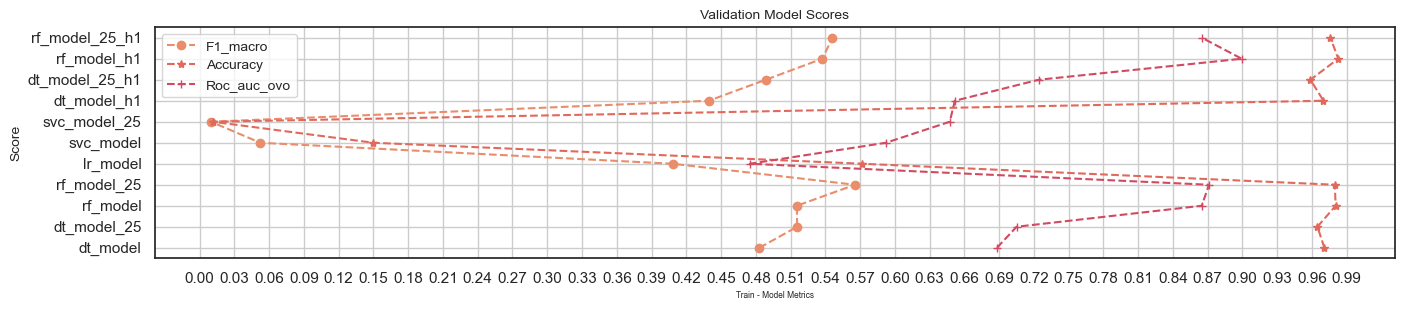

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

ax.plot(Model_scores_val['F1_macro'], Model_scores_val['Val - Model'], label='F1_macro', marker='o', linestyle='dashed')
ax.plot(Model_scores_val['Accuracy'], Model_scores_val['Val - Model'], label='Accuracy', marker='*', linestyle='dashed')
ax.plot(Model_scores_val['Roc_auc_ovo'], Model_scores_val['Val - Model'], label='Roc_auc_ovo', marker='+', linestyle='dashed')
ax.set_title('Validation Model Scores', fontsize=10)
ax.set_xlabel ('Train - Model Metrics', fontsize=6)
ax.set_ylabel ('Score', fontsize=10)
plt.legend(fontsize=10)
ax.set_xticks(np.arange(0., 1, 0.03))
plt.grid()

plt.show()

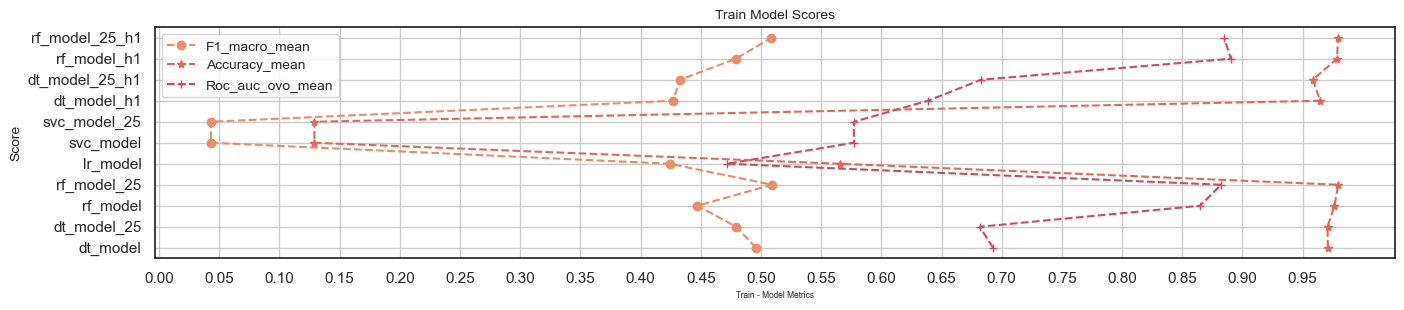

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

ax.plot(Model_scores_train['F1_macro_mean'], Model_scores_train['Train - Model'], label='F1_macro_mean', marker='o', linestyle='dashed')
ax.plot(Model_scores_train['Accuracy_mean'], Model_scores_train['Train - Model'], label='Accuracy_mean', marker='*', linestyle='dashed')
ax.plot(Model_scores_train['Roc_auc_ovo_mean'], Model_scores_train['Train - Model'], label='Roc_auc_ovo_mean', marker='+', linestyle='dashed')
ax.set_title('Train Model Scores', fontsize=10)
ax.set_xlabel ('Train - Model Metrics', fontsize=6)
ax.set_ylabel ('Score', fontsize=10)
plt.legend(fontsize=10)
ax.set_xticks(np.arange(0, 1, 0.05))
plt.grid()

plt.show()

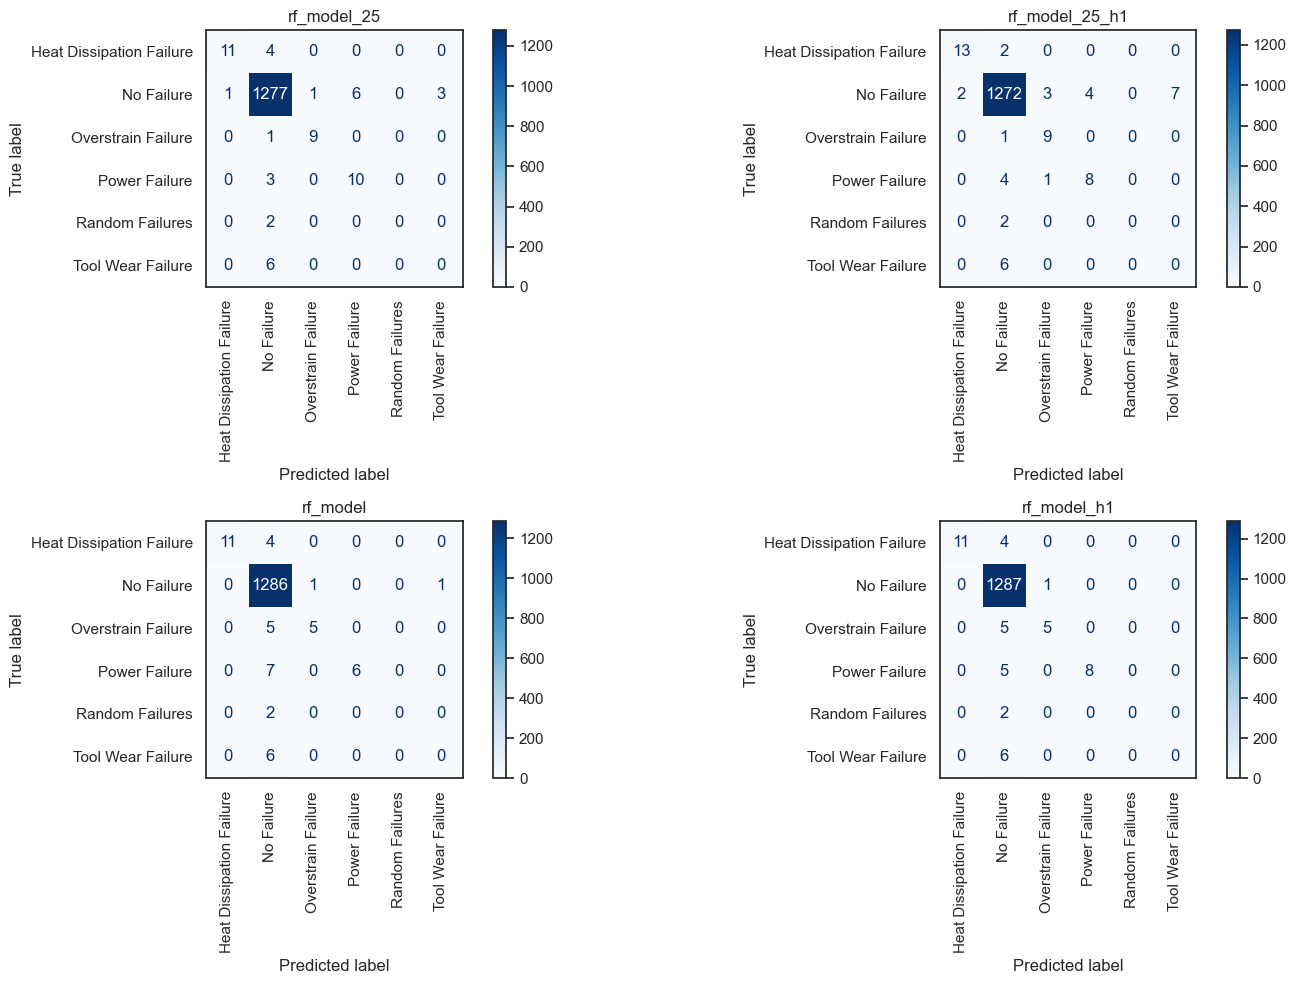

In [95]:
models = [rf_model_25, rf_model_25_h1, rf_model, rf_model_h1]
titles = ['rf_model_25', 'rf_model_25_h1','rf_model', 'rf_model_h1']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for model, ax, title in zip(models, axes.flatten(), titles):
    plot_confusion_matrix(model, 
                          num_X_val, 
                          num_y_val, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(title)
    ax.tick_params('x', labelrotation=90)
                          
plt.tight_layout()  
plt.show()

## Feature Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model.   
It can reduce the computational cost of modeling and, in some cases, can improve the performance of the model. However, this could also impair the performance of models of imbalanced datasets.

Feature selection for Random Forest can be done by using feature importante,  the score provided for each feature of the data, the higher the score more important or relevant is the feature towards your output variable.

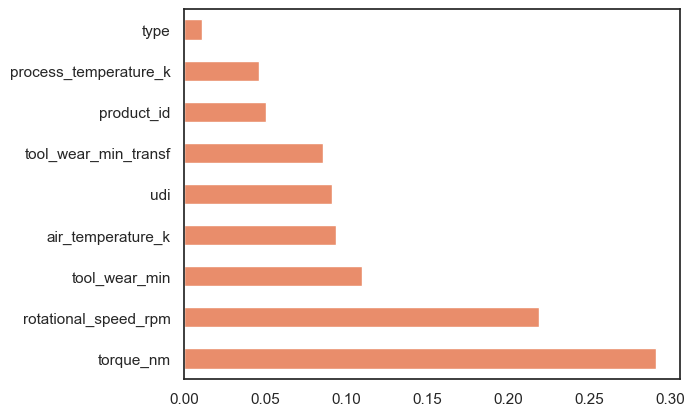

In [96]:
# Training a Random Forest Classifier Rf_model_25 to get features importances (Baseline Model)

# Creating a random forest classifier using tbest parameters applied in Rf_model_25
rf_model_25_= RandomForestClassifier(random_state=42)

# Training the classifier
rf_model_25_.fit(num_X_train25, num_y_train25)

#plotting graph of feature importances for better visualization
feat_importances = pd.Series(rf_model_25_.feature_importances_, index=num_X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The 'type' is the feature with low importance in the model. This feature was chosen to be removed as it is also highly correlated with 'product_id'.

In [97]:
from sklearn.feature_selection import SelectFromModel
# Create a selector object that will use the random forest classifier to identify the feature based on the importance score
rf_sf = SelectFromModel(rf_model_25_, threshold=0.02)

# Train the selector
rf_sf = rf_sf.fit(num_X_train25, num_y_train25)

# Transform the data to create a new dataset containing only the most important features
X_fs_train25 = rf_sf.transform(num_X_train25)
X_fs_val = rf_sf.transform(num_X_val)

In [99]:
# Training a new model using selected important features

# Create a new random forest classifier for the most important features
rf_model_25fs = RandomForestClassifier(random_state=42)

# Train the new classifier on the new dataset containing the most important features
rf_model_25fs = rf_model_25fs.fit(X_fs_train25, num_y_train25)

print(classification_report_imbalanced(num_y_val, rf_model_25fs.predict(X_fs_val), digits=3))
Model_scores_train.loc[len(Model_scores_train)] = cv_score('rf_model_25fs', rf_model_25fs, X_fs_train25, num_y_train25)
Model_scores_val.loc[len(Model_scores_val)] = val_score('rf_model_25fs', rf_model_25fs, X_fs_val, num_y_val)
Model_scores_val

                                pre       rec       spe        f1       geo       iba       sup

Heat Dissipation Failure      0.917     0.733     0.999     0.815     0.856     0.713        15
              No Failure      0.988     0.993     0.652     0.990     0.805     0.670      1288
      Overstrain Failure      0.889     0.800     0.999     0.842     0.894     0.783        10
           Power Failure      0.688     0.846     0.996     0.759     0.918     0.830        13
         Random Failures      0.000     0.000     1.000     0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.998     0.000     0.000     0.000         6

             avg / total      0.977     0.981     0.664     0.979     0.802     0.669      1334



Val - Model  F1_macro  Accuracy  Roc_auc_ovo
0         dt_model  0.483164  0.970765     0.688167
1      dt_model_25  0.515698  0.964768     0.705161
2         rf_model  0.515454  0.980510     0.864939
3      rf_model_25  0.565668  0.979760     0.871154
4         lr_model  0.408169  0.571964     0.474922
5        svc_model  0.052321  0.149925     0.592318
6     svc_model_25  0.009752  0.011244     0.647428
7      dt_model_h1  0.439353  0.970015     0.651811
8   dt_model_25_h1  0.488618  0.958771     0.724189
9      rf_model_h1  0.537367  0.982759     0.899450
10  rf_model_25_h1  0.546206  0.976012     0.865050
11   rf_model_25fs  0.567644  0.981259     0.882375

In [ ]:
models = [rf_model_25, rf_model_h1fs]
titles = ['rf_model_25', 'rf_model_25fs']
Xs = [num_X_val, X_fs_val]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for model, ax, title, x in zip(models, axes.flatten(), titles, Xs):
    plot_confusion_matrix(model, 
                          x, 
                          num_y_val, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(title)
    ax.tick_params('x', labelrotation=90)
                          
plt.tight_layout()  
plt.show()

**The feature selection slightly reduced the false positives values for 'No Failure' class, and maintained the sum of true positives values of all other failures types, being useful.**

# Conclusions

- The exploratory data analyses showed that the dataset in highly imbalanced and shows the presence of outliers.
- The dataset was preprocessed from categorical to numerical data and oversampled using SMOTE method.
- Several machine learnig models were built with their baseline parameters.
- The models were fitted with the numerical dataset, with and without oversampling, in order to classify the data in one of failure classes. 
- Hyperparameter tunning were applied to models with better initial performance, taking into account - F1 Macro score, ROC_AUC and accuracy. 
- The hyperparameter tunning did not improve the models ccompared to baseline parameters. However the oversampling method showed improved model scores.
- The Random Forest method was chosen to predict the test_dataset. This model is a robust classifier, insensible to outliers (the outlier were not treated), with low risk of overfitting (if hyperparameter tunned). The Random Forest model have some limitations: it can also be biased while dealing with categorical variables and can train slowly.


# Predicting the values for the Test dataset

## Data preprocessing

Applying the same preprocessing steps that were used for the train dataset.

In [100]:
machine_test_num = machine_test.copy()
machine_test_num['tool_wear_min_transf'] = machine_test_num['tool_wear_min'] + machine_test_num['type'].replace(['H', 'M', 'L'], [5, 3, 2])
machine_test_num.sample(5)

udi product_id type  air_temperature_k  process_temperature_k  \
1808  5486     L52665    L              302.6                  312.1   
1640  9352     L56531    L              298.3                  308.8   
1279  4172     M19031    M              302.2                  310.5   
653   5054     L52233    L              303.8                  312.9   
1050  6654     M21513    M              301.4                  310.3   

      rotational_speed_rpm  torque_nm  tool_wear_min  tool_wear_min_transf  
1808                  1344       51.0            206                   208  
1640                  1645       30.4             33                    35  
1279                  1832       23.7            129                   132  
653                   1514       34.3            180                   182  
1050                  1610       29.1            166                   169

In [101]:
machine_test_num['type'] = machine_test_num['type'].replace(['L', 'M', 'H'],[1, 2, 3])
machine_test_num.head(5)

udi product_id  type  air_temperature_k  process_temperature_k  \
0   446     L47625     1              297.5                  308.6   
1  7076     L54255     1              300.7                  310.5   
2  1191     L48370     1              297.2                  308.4   
3  2618     L49797     1              299.4                  309.1   
4  5067     L52246     1              304.1                  313.1   

   rotational_speed_rpm  torque_nm  tool_wear_min  tool_wear_min_transf  
0                  1793       26.7             70                    72  
1                  1536       47.4            192                   194  
2                  1460       42.1             41                    43  
3                  1670       35.9             68                    70  
4                  1550       30.9              9                    11

In [102]:
machine_test_num['product_id'] = machine_test_num['product_id'].map(lambda x: x.strip('LMH')).astype('int')

# Removing the feature 'type'
machine_test_num = machine_test_num.drop(columns='type')

In [103]:
# Separate feature columns and target column
machine_test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    3333 non-null   int64  
 1   product_id             3333 non-null   int32  
 2   air_temperature_k      3333 non-null   float64
 3   process_temperature_k  3333 non-null   float64
 4   rotational_speed_rpm   3333 non-null   int64  
 5   torque_nm              3333 non-null   float64
 6   tool_wear_min          3333 non-null   int64  
 7   tool_wear_min_transf   3333 non-null   int64  
dtypes: float64(3), int32(1), int64(4)
memory usage: 195.4 KB


In [104]:
pd.DataFrame(X_fs_train25).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6864 non-null   float64
 1   1       6864 non-null   float64
 2   2       6864 non-null   float64
 3   3       6864 non-null   float64
 4   4       6864 non-null   float64
 5   5       6864 non-null   float64
 6   6       6864 non-null   float64
 7   7       6864 non-null   float64
dtypes: float64(8)
memory usage: 429.1 KB


In [105]:
# Predicing the Y test values
prediction = rf_model_25fs.predict(machine_test_num)

# Converting the predicion data to a dataframe
submission = pd.DataFrame(prediction)
submission.columns = ['predictedValues']

#Saving the data in a CSV file
submission.to_csv('test_predicted.csv', index=True, index_label= 'rowNumber')

In [106]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   predictedValues  3333 non-null   object
dtypes: object(1)
memory usage: 26.2+ KB


In [107]:
submission

predictedValues
0         No Failure
1         No Failure
2         No Failure
3         No Failure
4         No Failure
...              ...
3328      No Failure
3329      No Failure
3330      No Failure
3331      No Failure
3332      No Failure

[3333 rows x 1 columns]

In [108]:
submission.value_counts()

predictedValues         
No Failure                  3206
Heat Dissipation Failure      35
Power Failure                 34
Tool Wear Failure             31
Overstrain Failure            27
dtype: int64